In [12]:
import numpy as np
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.splatalogue import utils, Splatalogue
import scipy.constants as cnst
from astropy.io import fits
import glob
from astropy.modeling import models#Fittable1DModel, Parameter, fitting
from utilities import *#Q_rot_asym,mulu,vradio,t_rad,nupper_estimated,opticaldepth,qngrabber
import matplotlib as mpl
import pdb
import sys
from manualspeciesabundances import *
from spectral_cube import SpectralCube as sc
import radio_beam
from astropy.wcs import WCS
from astropy.table import QTable, vstack

In [23]:
Splatalogue.QUERY_URL= 'https://splatalogue.online/c_export.php'

mpl.interactive(True)

plt.close('all')

def lineprofile(sigma,nu_0,nu):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(nu-nu_0)**2/(2*sigma**2))

def cdms_get_molecule_name(my_molecule_name, **kwargs):
    basename = dict(CDMS.query_lines(min_frequency=1*u.GHz, max_frequency=500*u.GHz, molecule=my_molecule_name, parse_name_locally=True, get_query_payload=True, **kwargs))['Molecules']
    return " ".join(basename.split(" ")[1:])

'''Collect constants for N_tot and N_upper calculations'''

source='DSi'
fnum=fields[source]
dpi={0:150,1:300}
mode=dpi[0]

c=cnst.c*u.m/u.s
k=cnst.k*u.J/u.K
h=cnst.h*u.J*u.s
sigma_sb=cnst.sigma*u.W/((u.m)**(2)*(u.K)**(4))
Tbg=2.7355*u.K
cdms_catdir=CDMS.get_species_table()
jpl_catdir=JPLSpec.get_species_table()

sanitykeylist={'DSi':0, 'DSii':1, 'DSiii':2, 'DSiv':3, 'DSv':4, 'DSVI':5, 'DSVII':6, 'DSVIII':7, 'DSIX':8, 'SgrB2S':9, 'DS10':10}

trotdict={'SgrB2S':300*u.K,'DSi':300*u.K,'DSii':150*u.K,'DSiii':150*u.K,'DSiv':150*u.K,
          'DSv':100*u.K,'DSVI':300*u.K,'DSVII':200*u.K,'DSVIII':215*u.K,'DSIX':150*u.K,'DS10':150*u.K}

testT=trotdict[source]
ch3ohpropertytable=QTable.read(ch3ohpropertytablepath)

aces_cubes = {spw: f'/orange/adamginsburg/ACES/upload/Feather_12m_7m_TP/SPW{spw}/cubes/Sgr_A_st_b.TP_7M_12M_feather_all.SPW_{spw}.image.statcont.contsub.fits'
                  for spw in (25, 27, 33, 35)}
continuum_cube = sc.read('/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_Xa6/calibrated/working/uid___A001_X15a0_Xa6.s36_0.Sgr_A_star_sci.v1aggregated_spw25_27_29_31_33_35.cont.I.iter1.image.tt0.pbcor', format='casa_image').to(u.K)

dopplershifts={'SgrB2S':0.000228,'DSi':0.0001865,'DSii':0.000163,'DSiii':0.00017500261911843952,'DSiv':0.00018225233186845314,'DSv':0.0001838576164010067,'DSVI':0.0001661613132158407,'DSVII':0.00016320118280935546,'DSVIII':0.0001662062062062062,'DSIX':0.00015453732389175085,'DS10':0.00015794099431186572}#:0.000190713}/old doppler S: 0.0002306756533745274/0.00015954965399894244/0.00016236367659115043
pixdict={'SgrB2S':(70,59),'DSi':(36,42),'DSii':(22,24),'DSiii':(24,24),'DSiv':(32,31),'DSv':(19,19),'DSVI':(62,62),'DSVII':(75,75),'DSVIII':(50,50),'DSIX':(34,32),'DS10':(35,35)}#SgrB2S:61,64, DSIX:(34,35)
targetpix=pixdict[source]

s_othermol_dshift_v={' CH3CHO ':67.45330305*u.km/u.s,' C2H5OH ':67.45330305*u.km/u.s,' CH3OCHO ':67.45330305*u.km/u.s,' C(18)O ':69.551850256*u.km/u.s,' 13CH3OH ':67.5*u.km/u.s,' SO ':70.5*u.km/u.s}#' CH3OH ':68352.680424
ds2_othermol_dshift_v={' CH3OCHO ':49*u.km/u.s,' CH3CHO ':49*u.km/u.s,' C2H5OH ':49.3*u.km/u.s}#47831.782945392486 m / s
ds5_othermol_dshift_v={}
othermol_dopplershift={' CH3CHO ':0.000225,' C2H5OH ':0.000225,' CH3OCHO ':0.000225,' C(18)O ':0.000232}
ds9_othermol_dshift_v={}

sourceothers={'SgrB2S':s_othermol_dshift_v,'DSi':{},'DSii':ds2_othermol_dshift_v,'DSiii':{},'DSiv':{},'DSv':ds5_othermol_dshift_v,'DSVI':{},'DSVII':{},'DSVIII':{},'DSIX':ds9_othermol_dshift_v,'DS10':{}}
othermol_dshift_v=sourceothers[source]

z=dopplershifts[source]
z_vel=z*c

assemblecubepath=minicube_base+f'{source}/'+minicube_end[fnum]+'*.fits'
print(f'Collecting spectra from {assemblecubepath}')
spectra=glob.glob(assemblecubepath)
spectra.sort()

homedict={'SgrB2S':'/blue/adamginsburg/d.jeff/XCLASS2021/files/SgrB2S/OctReimage_K/','DSi':'/blue/adamginsburg/d.jeff/XCLASS2021/files/DSi/field10originals_K/','DSii':'/blue/adamginsburg/d.jeff/XCLASS2021/files/DSii/field10originals_K/','DSiii':'/aug2023qrotfix/','DSiv':'/aug2023qrotfix/','DSv':f'/aug2023qrotfix/','DSVI':'/aug2023qrotfix/','DSVII':f'/aug2023qrotfix/','DSVIII':f'/aug2023qrotfix/','DSIX':f'/aug2023qrotfix/'}
sourcepath=ch3oh_sourcedict[source]
origsourcepath=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}{sourcepath}'

texmappath=origsourcepath+'bootstrap_texmap_3sigma_allspw_withnans_weighted.fits'
    
fwhmpath=glob.glob(origsourcepath+'*fwhm*')[0]
nch3ohpath=glob.glob(origsourcepath+'ntotmap_allspw_withnans_weighted_useintercept_3sigma.fits')[0]
contpath=origsourcepath+'reprojectedcontinuum.fits'

texmapdata=fits.getdata(texmappath)*u.K
fwhmmap=fits.getdata(fwhmpath)*u.km/u.s
nch3ohmap=fits.getdata(nch3ohpath)*u.cm**-2

testT=texmapdata[targetpix[0],targetpix[1]]#350*u.K
fwhm_at_pix=fwhmmap[targetpix[0],targetpix[1]]
nch3oh_at_pix=nch3ohmap[targetpix[0],targetpix[1]]
#print(fwhm_at_pix)

hotcoreradius=1500*u.AU#ch3ohpropertytable['Radius'][sanitykeylist[source]]
contrestfreq=continuum_cube[0].header['RESTFRQ']*u.Hz
cntmbeam=radio_beam.Beam.from_fits_header(continuum_cube[0].header)
fillfactor=((hotcoreradius)**2/(radio_beam.Beam.beam_projected_area(cntmbeam,dGC).to('AU2')/np.pi))**2
if fillfactor >= 1:
    fillfactor=1
print(f'Fill factor: {fillfactor}')

stds=glob.glob(origsourcepath+'errorimgs/std/*.fits')
stds.sort()
images=['spw0','spw1','spw2','spw3']
    
assert 'spw0' in spectra[0] and 'spw0' in stds[0], 'List out of order'

print('Spectra and stds are sequential order')
linewidth=fwhm_at_pix#2.5*u.km/u.s#2.5 km/s is ideal for DSVI
print(f'Absolute model line width: {linewidth}\n')

sourcecolumns={'SgrB2S':sgrb2scolumns,'DSi':dsicolumns, 'DSii':ds2columns,'DSiii':ds3columns,'DSiv':ds4columns,
               'DSv':ds5columns,'DSVI':ds6columns,'DSVII':ds7columns,'DSVIII':ds8columns,'DSIX':ds9columns,'DS10':ds10columns}

columndict=sourcecolumns[source]
molcolors=['red','cyan','orange','brown','deepskyblue','darkviolet','yellow','pink','gold','darkkhaki',
           'silver','blue','lime','blue','grey','plum','fuchsia','darkcyan','magenta','deeppink',
           'gold','palegreen','goldenrod','indigo','dodgerblue','mediumpurple','yellow','red','grey']
spwmoldict={}
dummylist=[]
p1firstmolline={}
p2firstmolline={}
p3firstmolline={}
p4firstmolline={}
p5firstmolline={}
p6firstmolline={}
firstmolline=p1firstmolline
plotspecpad=0.005*u.GHz
n=1

cdms_catdir_qrot_temps=np.array([1000,500,300,225,150,75,37.5,18.75,9.375,5,2.725])
jpl_catdir_qrot_temps=[300, 225, 150, 75, 37.5, 18.75, 9.375]

aces=[[85.965625,86.434375],[86.665625,87.134375],[97.6625,99.5375],[99.5625,101.4375]]*u.GHz#[89.159231,89.217821],[87.895942,87.954532]

linedetections={}
for m in columndict.keys():
    p1firstmolline.update({m:1})
    p2firstmolline.update({m:1})
    p3firstmolline.update({m:1})
    p4firstmolline.update({m:1})
    p5firstmolline.update({m:1})
    p6firstmolline.update({m:1})
    
ww = WCS(fits.getheader(texmappath))
coord = ww.pixel_to_world(targetpix[1], targetpix[0])


divide by zero encountered in scalar remainder


Fill factor: 0.0029394414819902833
Spectra and stds are sequential order
Absolute model line width: 4.193309284658473 km / s



Getting ready - spw25
Extracted spectrum from 545, 1470 has peak 2.5186360724382544 K
Extracted continuum from 644, 1535 has value 0.49287357015292577 K
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw25. Continue
No transitions for  OCS  in spw25. Continue
Begin model loops for  13CH3OH 
No transitions for  H2CO  in spw25. Continue
No transitions for  HC3N  in spw25. Continue
No transitions for  C(18)O  in spw25. Continue
No transitions for  13CS  in spw25. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw25. Continue
Begin model loops for  SO 
Begin model loops for  SiO 
No transitions for  H2S  in spw25. Continue
Begin model loops for  c-HCCCH 
No transitions for HC3N v7=1 in

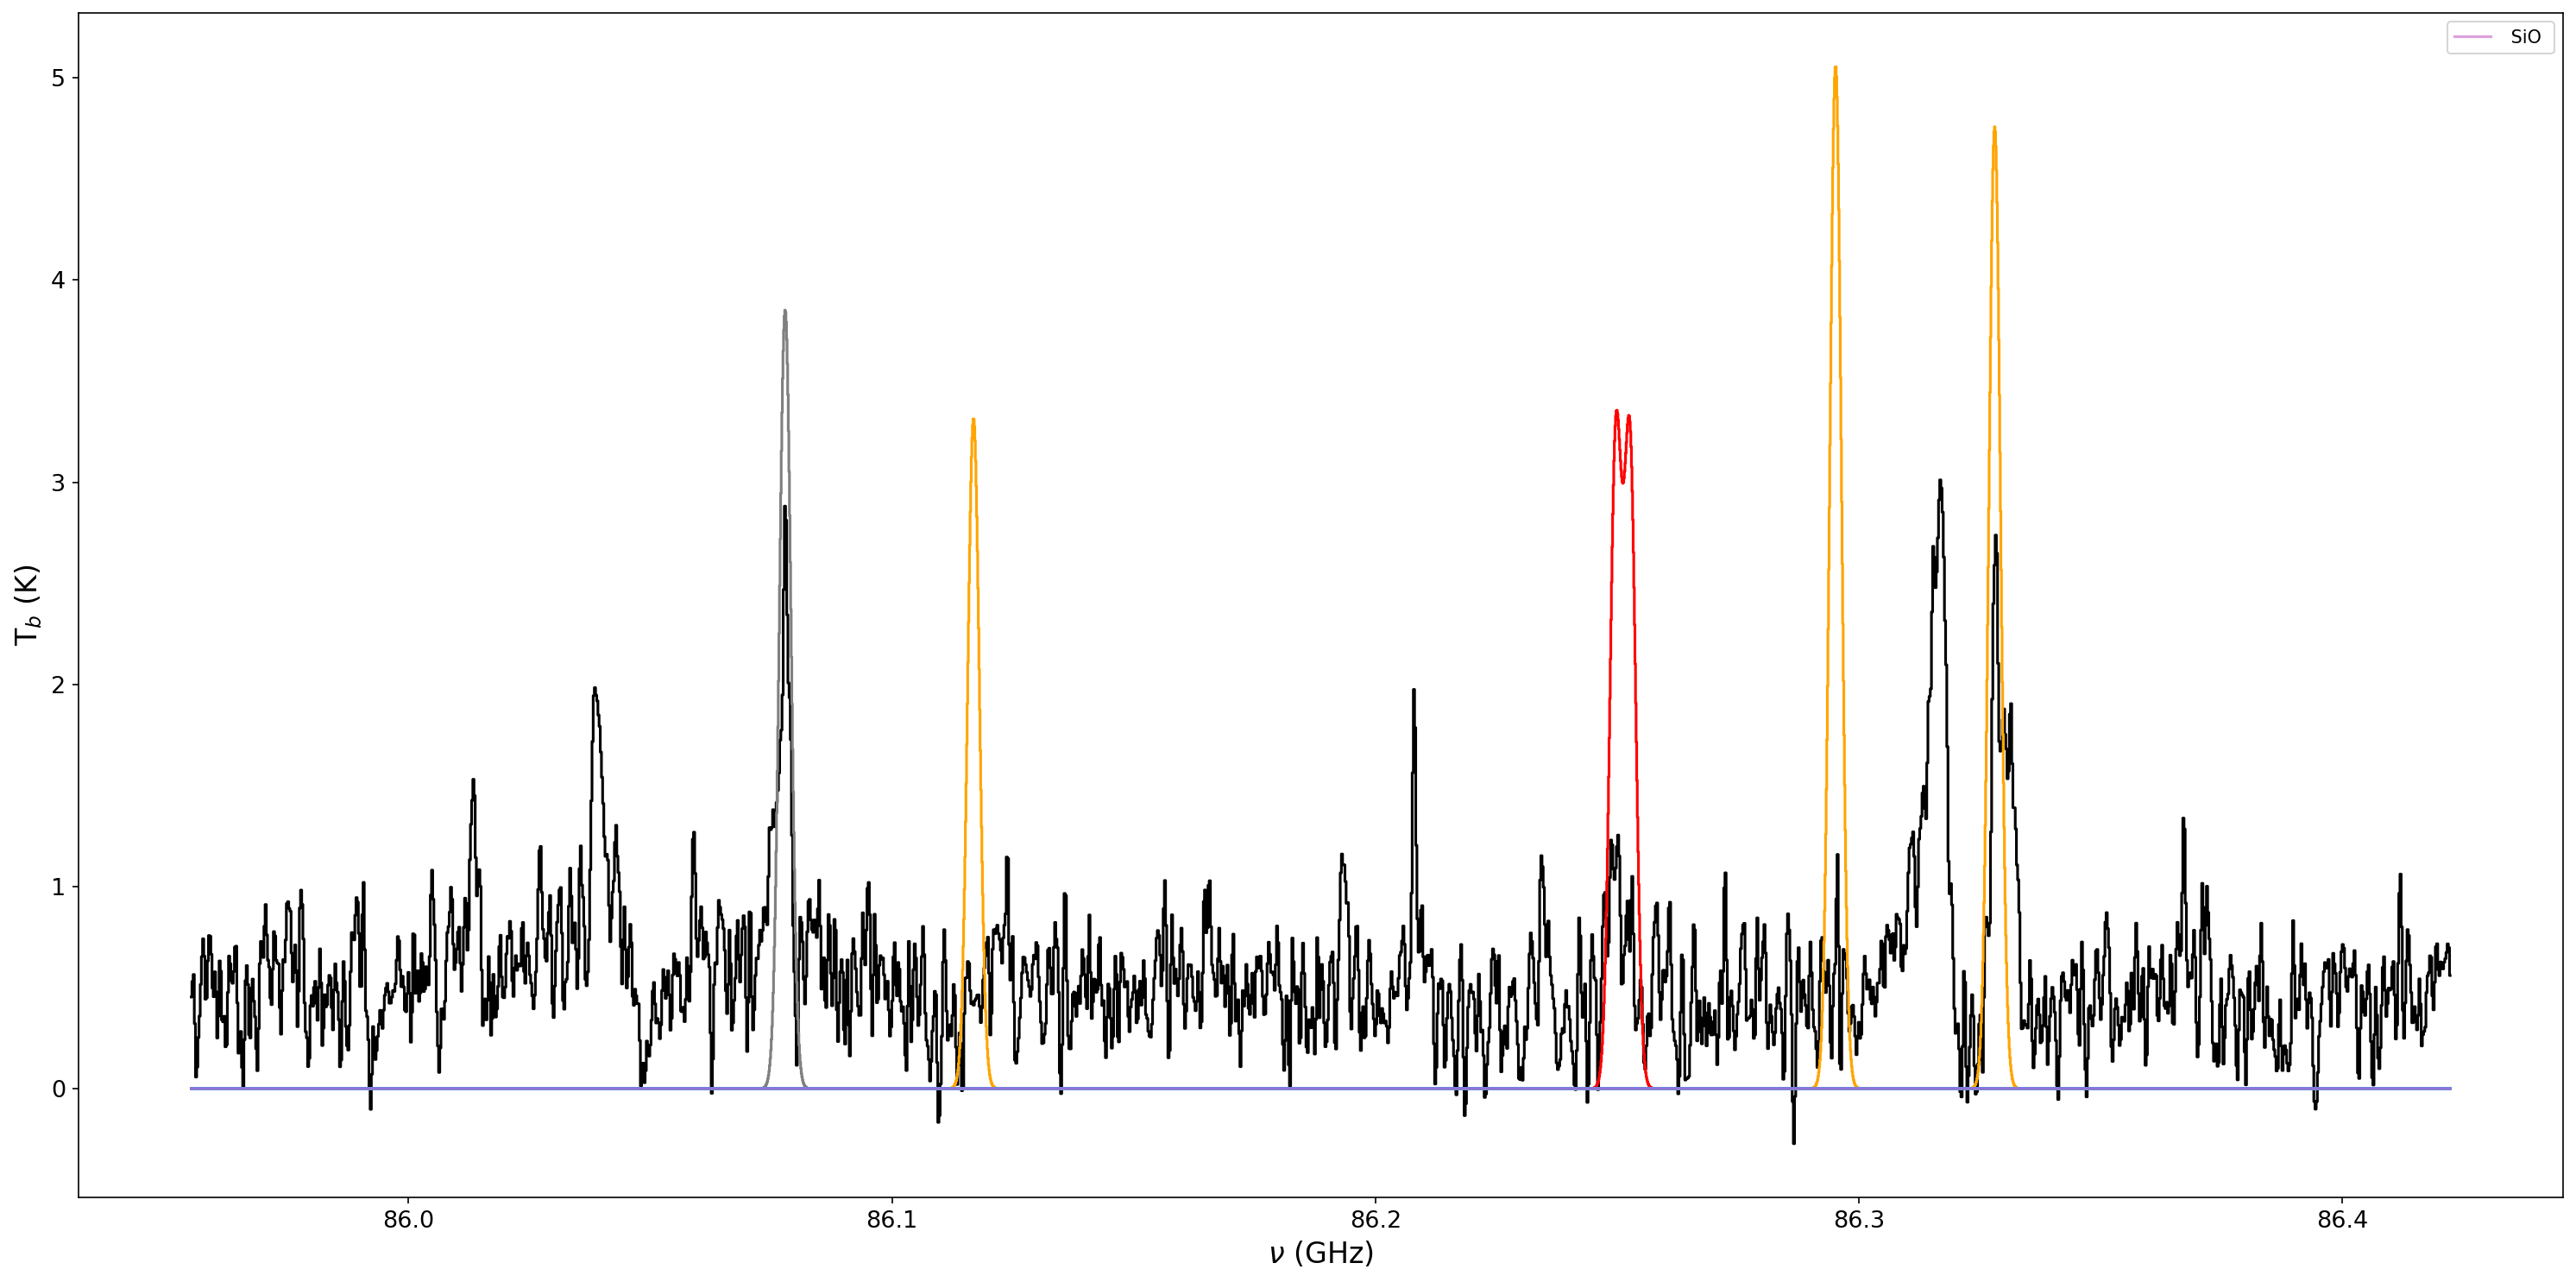

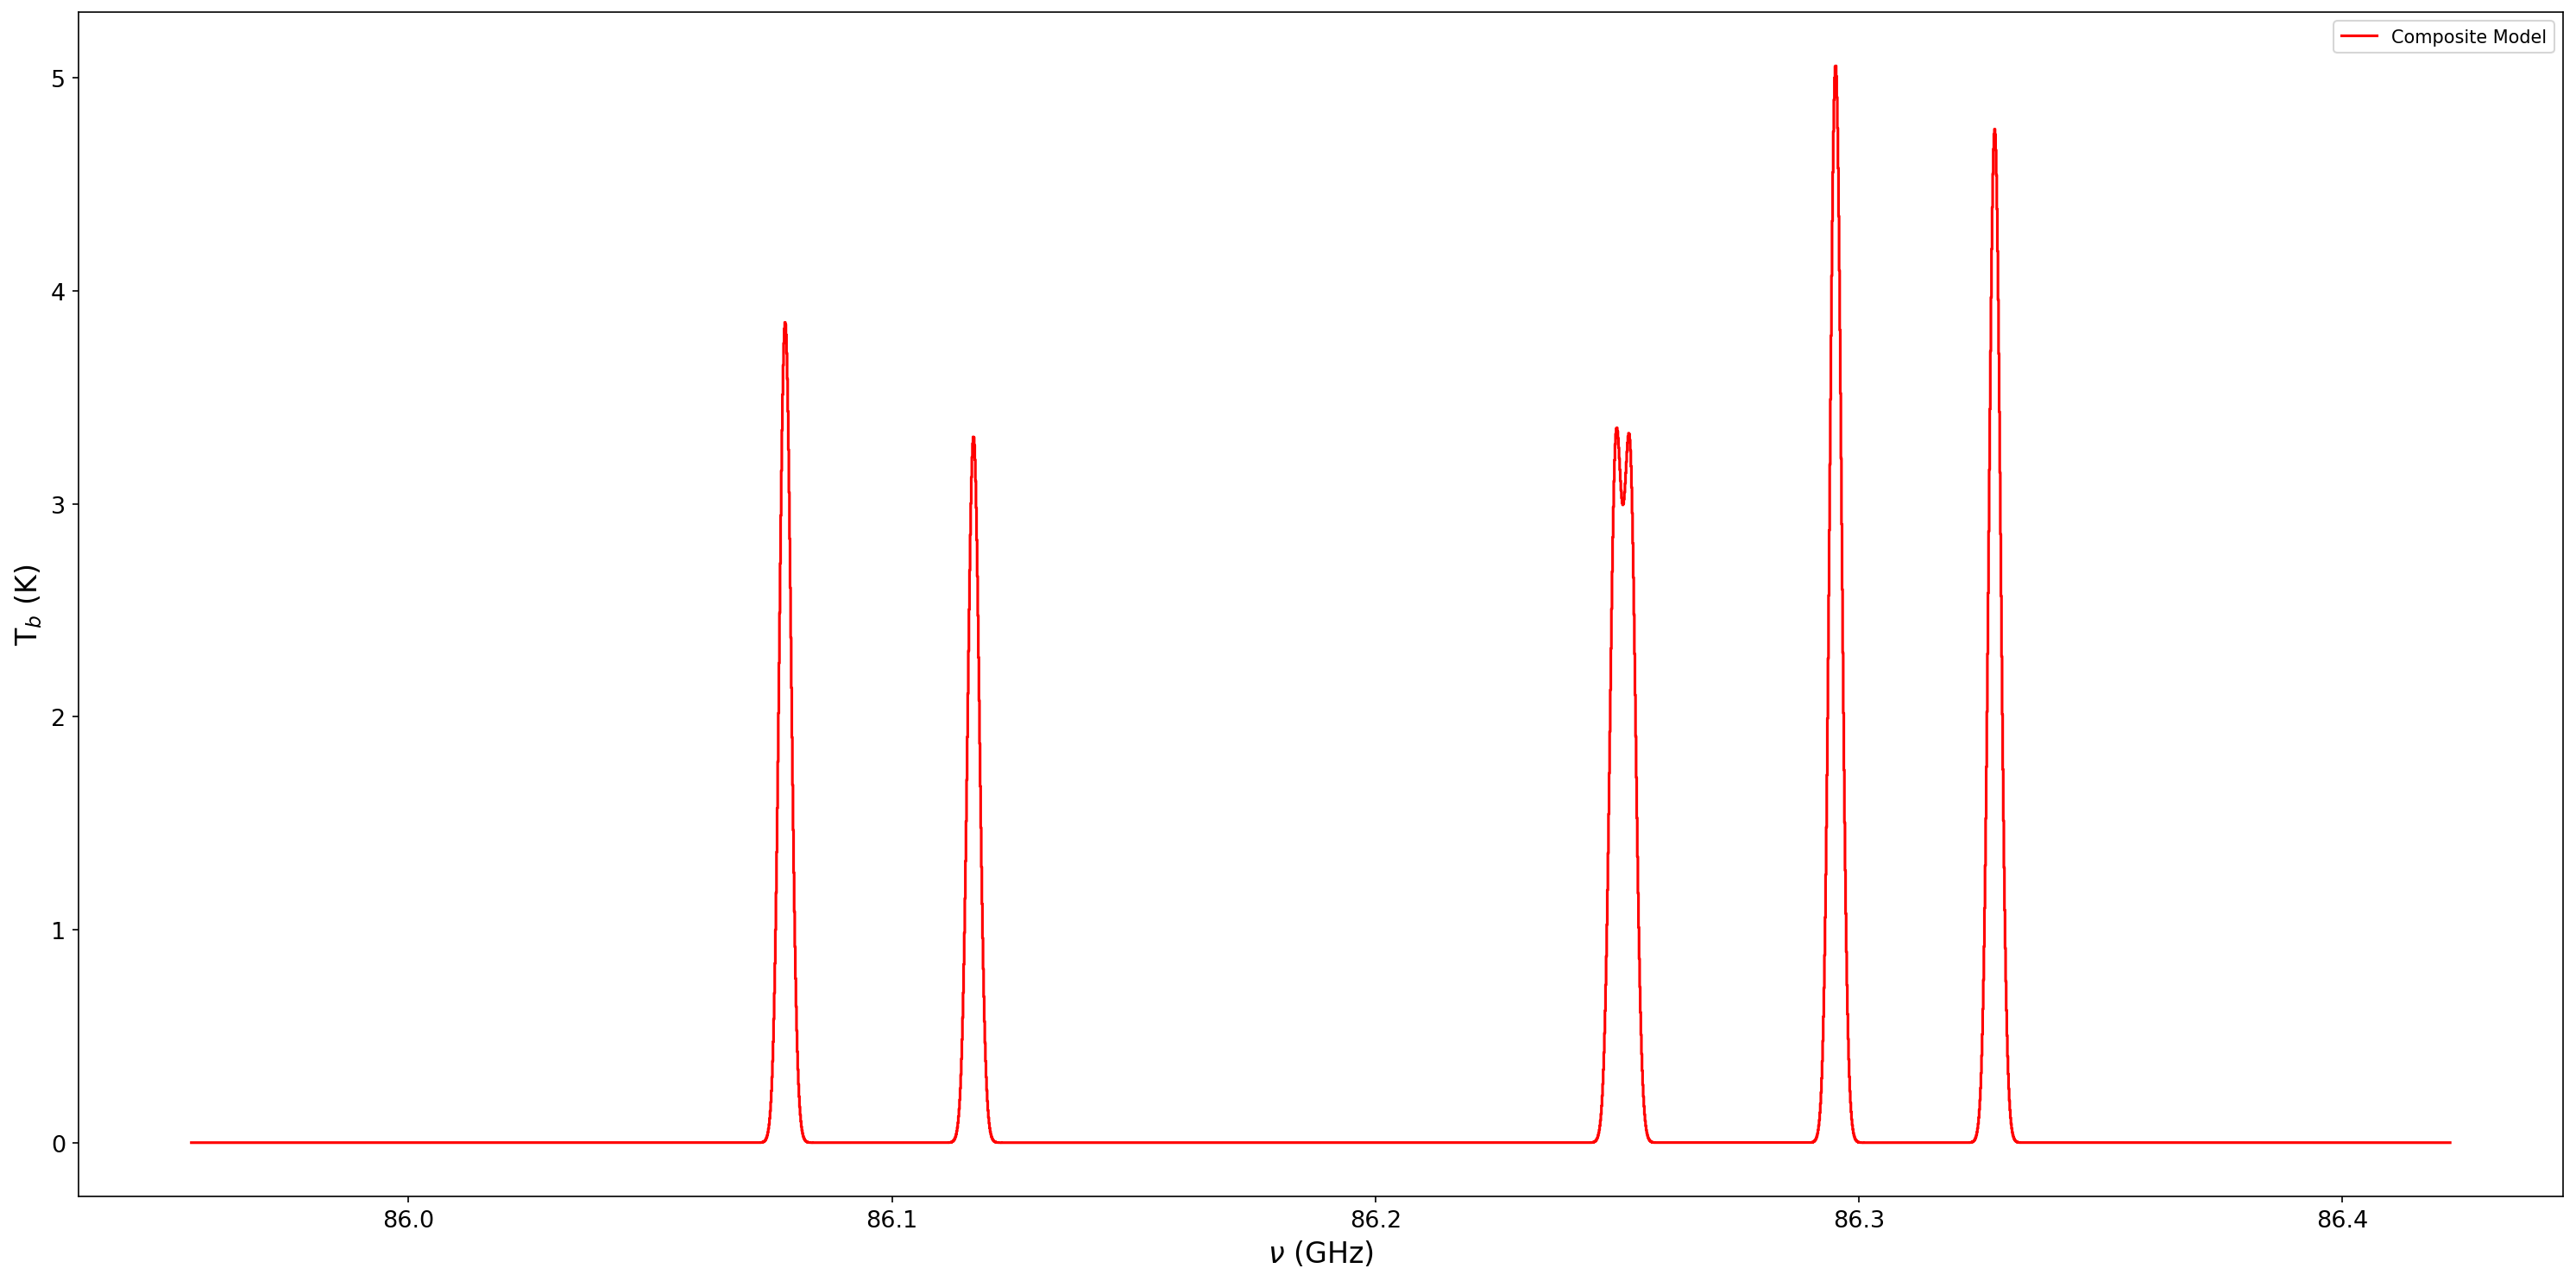

Getting ready - spw27
Extracted spectrum from 544, 1469 has peak 3.508001570592266 K
Extracted continuum from 644, 1535 has value 0.49287357015292577 K
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw27. Continue
No transitions for  OCS  in spw27. Continue
No transitions for  13CH3OH  in spw27. Continue
No transitions for  H2CO  in spw27. Continue
No transitions for  HC3N  in spw27. Continue
No transitions for  C(18)O  in spw27. Continue
No transitions for  13CS  in spw27. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw27. Continue
No transitions for  SO  in spw27. Continue
Begin model loops for  SiO 
No transitions for  H2S  in spw27. Continue
No transitions for  c-HCCCH  in 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


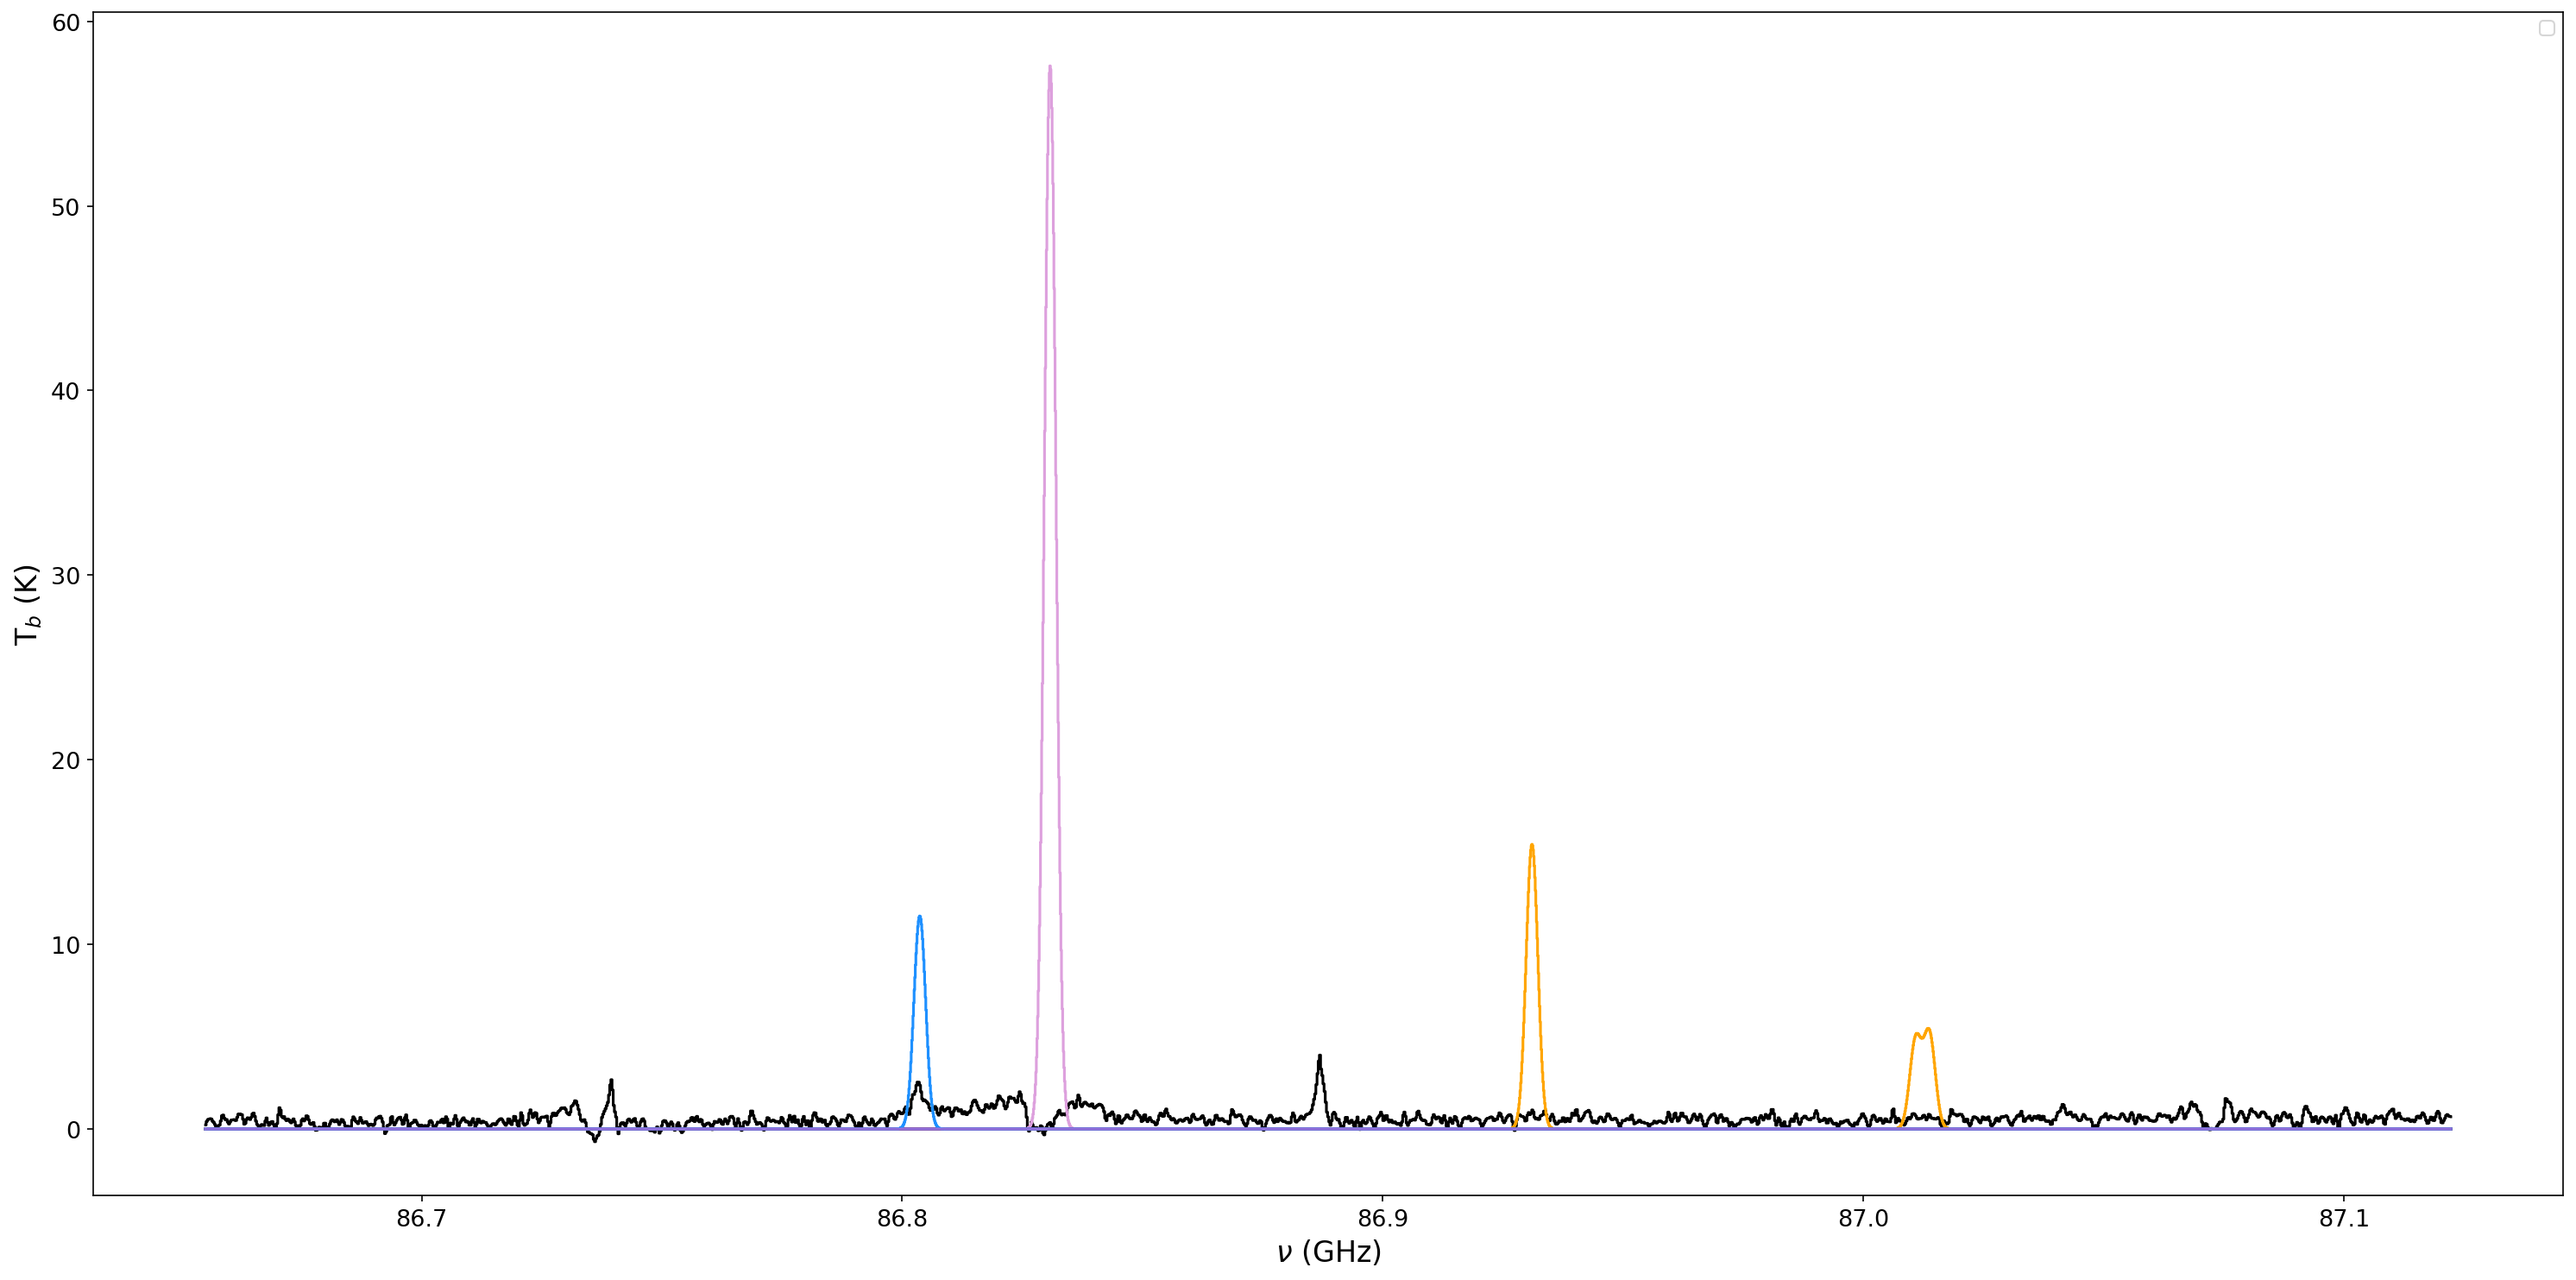

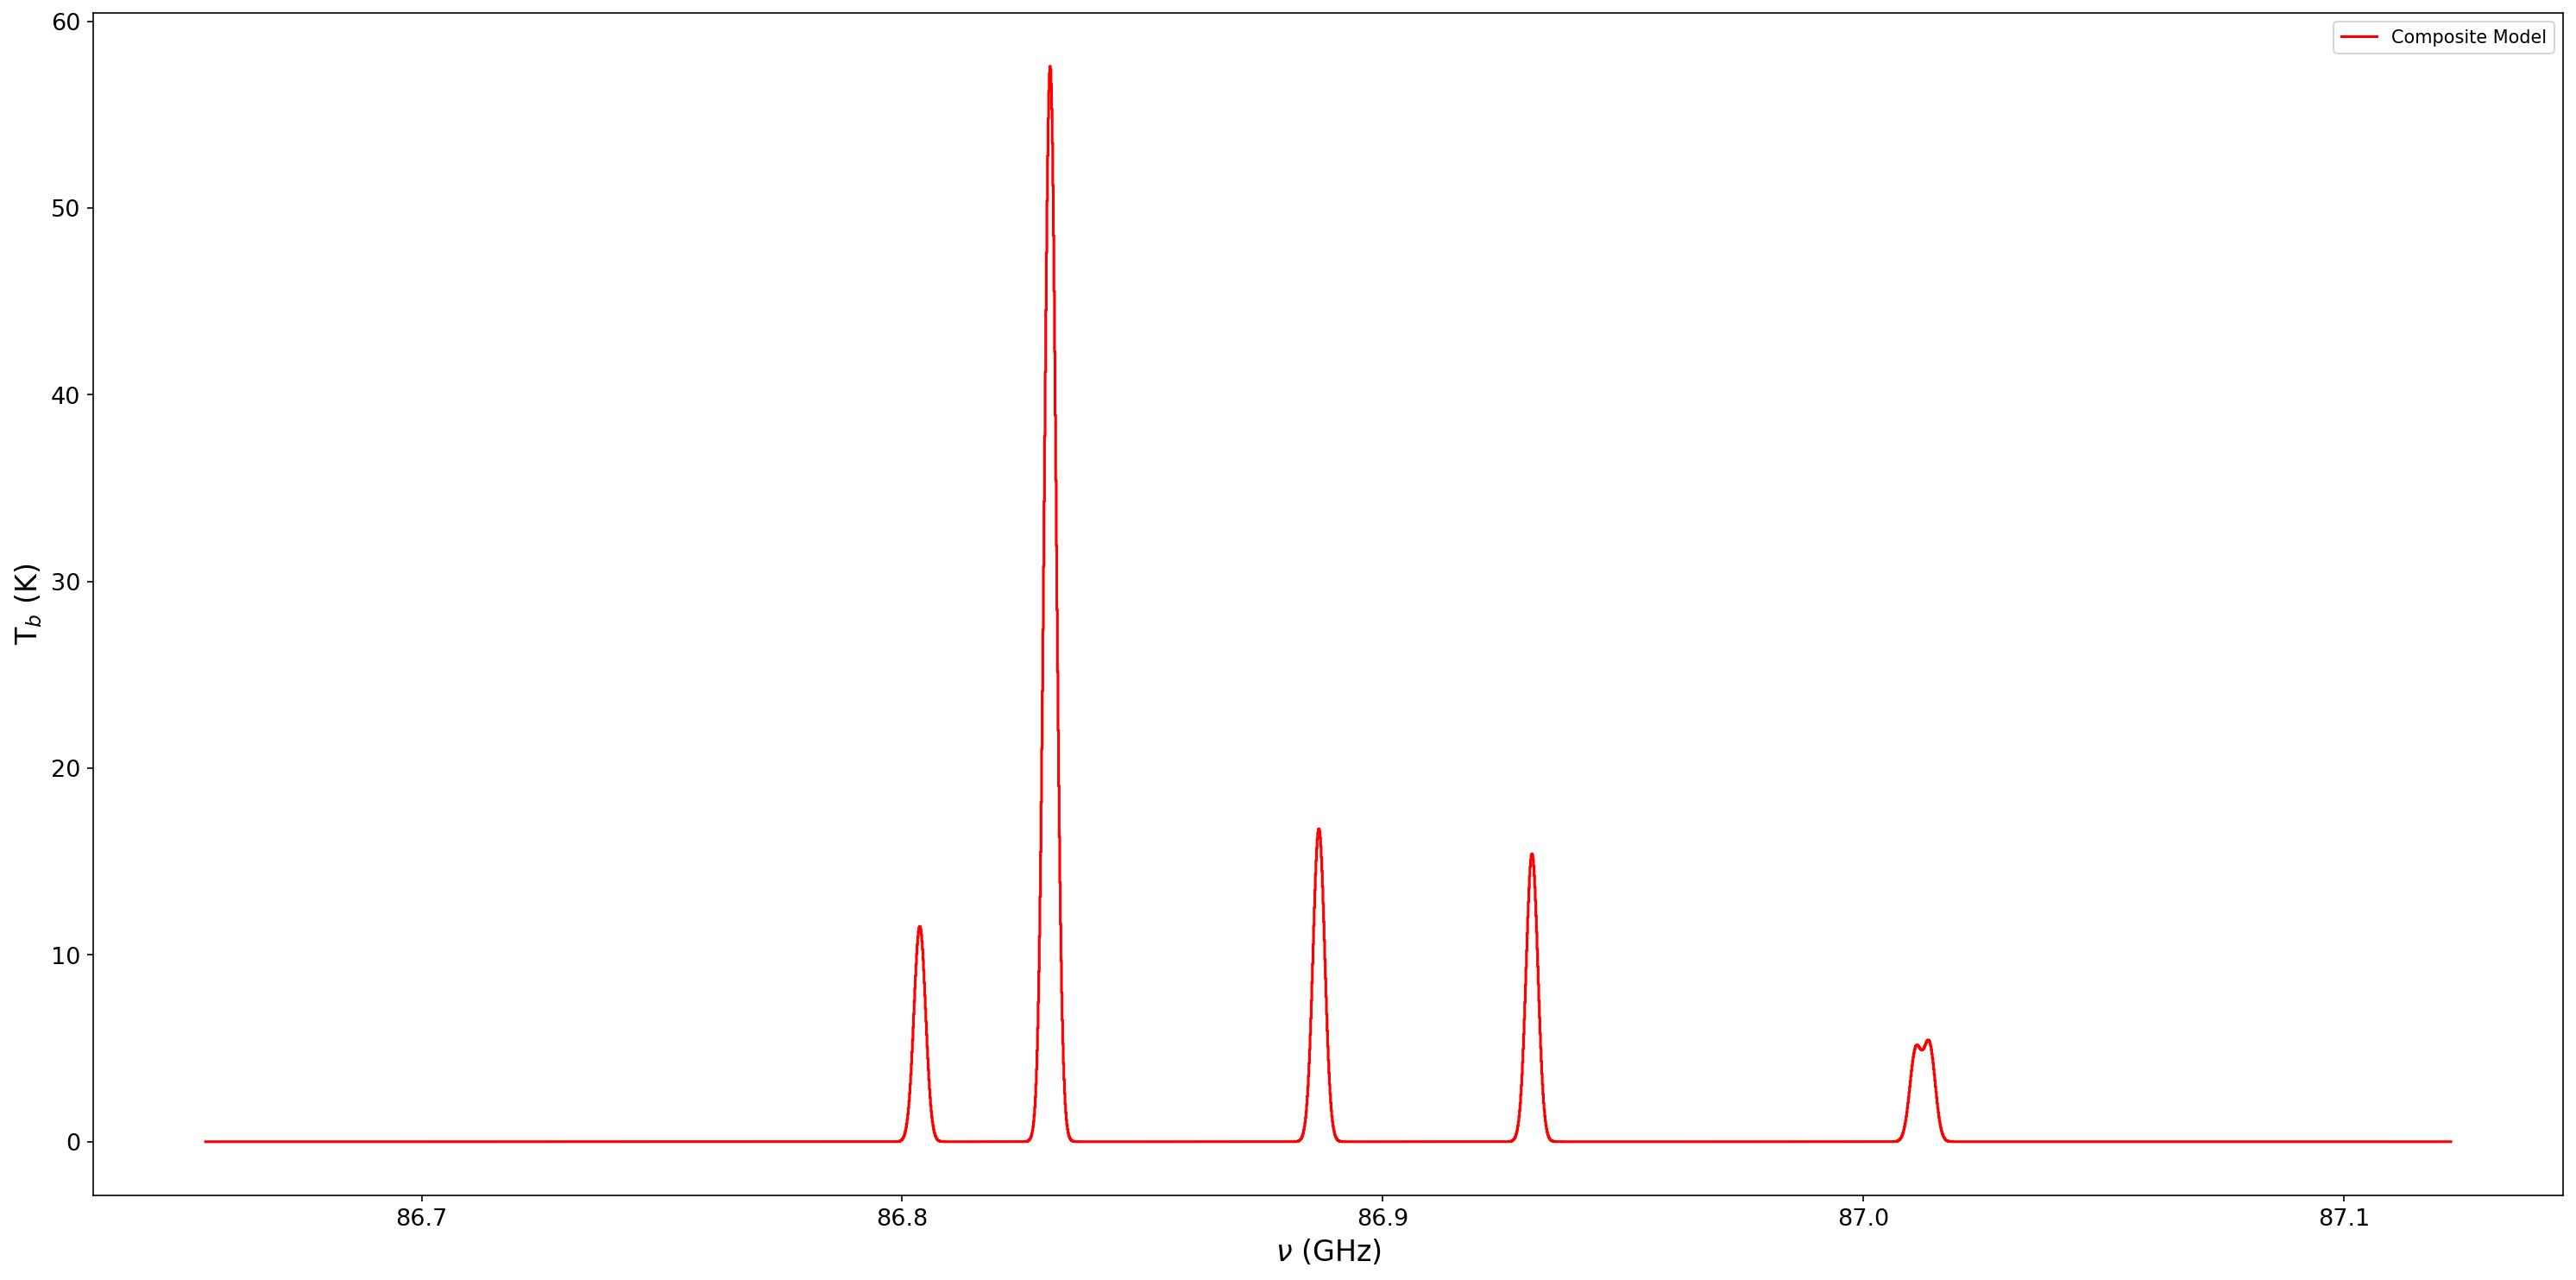

Getting ready - spw33
Extracted spectrum from 528, 1448 has peak 6.434672327097861 K
Extracted continuum from 644, 1535 has value 0.49287357015292577 K
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw33. Continue
No transitions for  OCS  in spw33. Continue
Begin model loops for  13CH3OH 
No transitions for  H2CO  in spw33. Continue
No transitions for  HC3N  in spw33. Continue
No transitions for  C(18)O  in spw33. Continue
No transitions for  13CS  in spw33. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw33. Continue
Begin model loops for  SO 
No transitions for  SiO  in spw33. Continue
No transitions for  H2S  in spw33. Continue
No transitions for  c-HCCCH  in spw33. Continue


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Begin CH3OH modeling



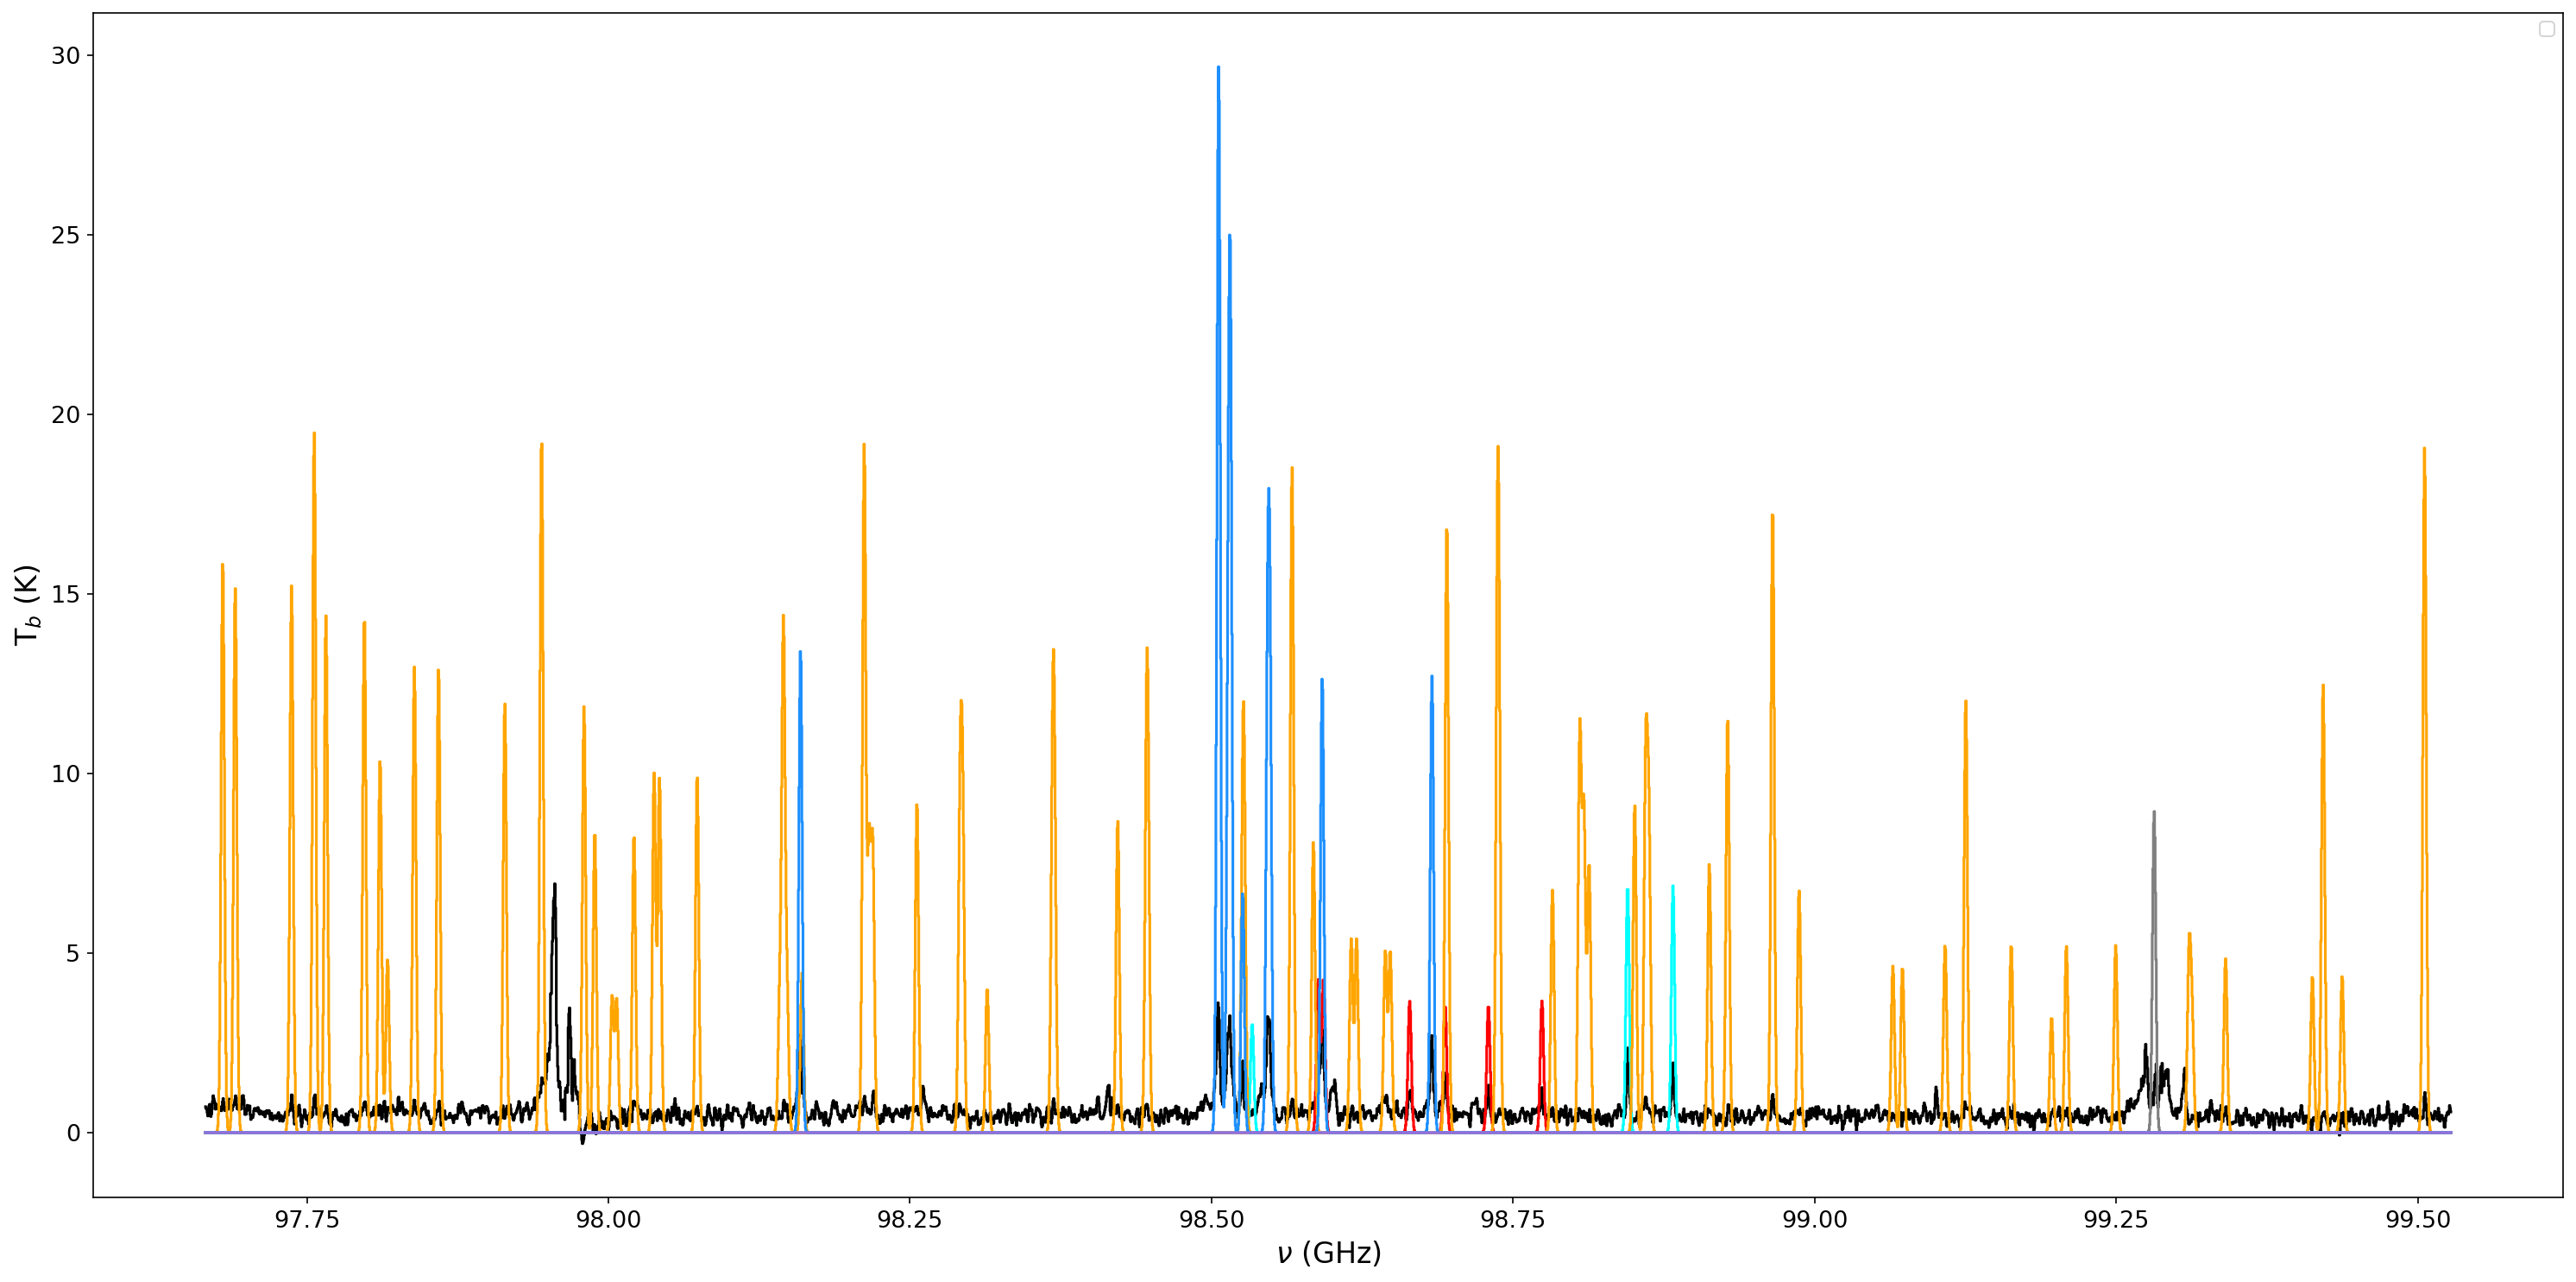

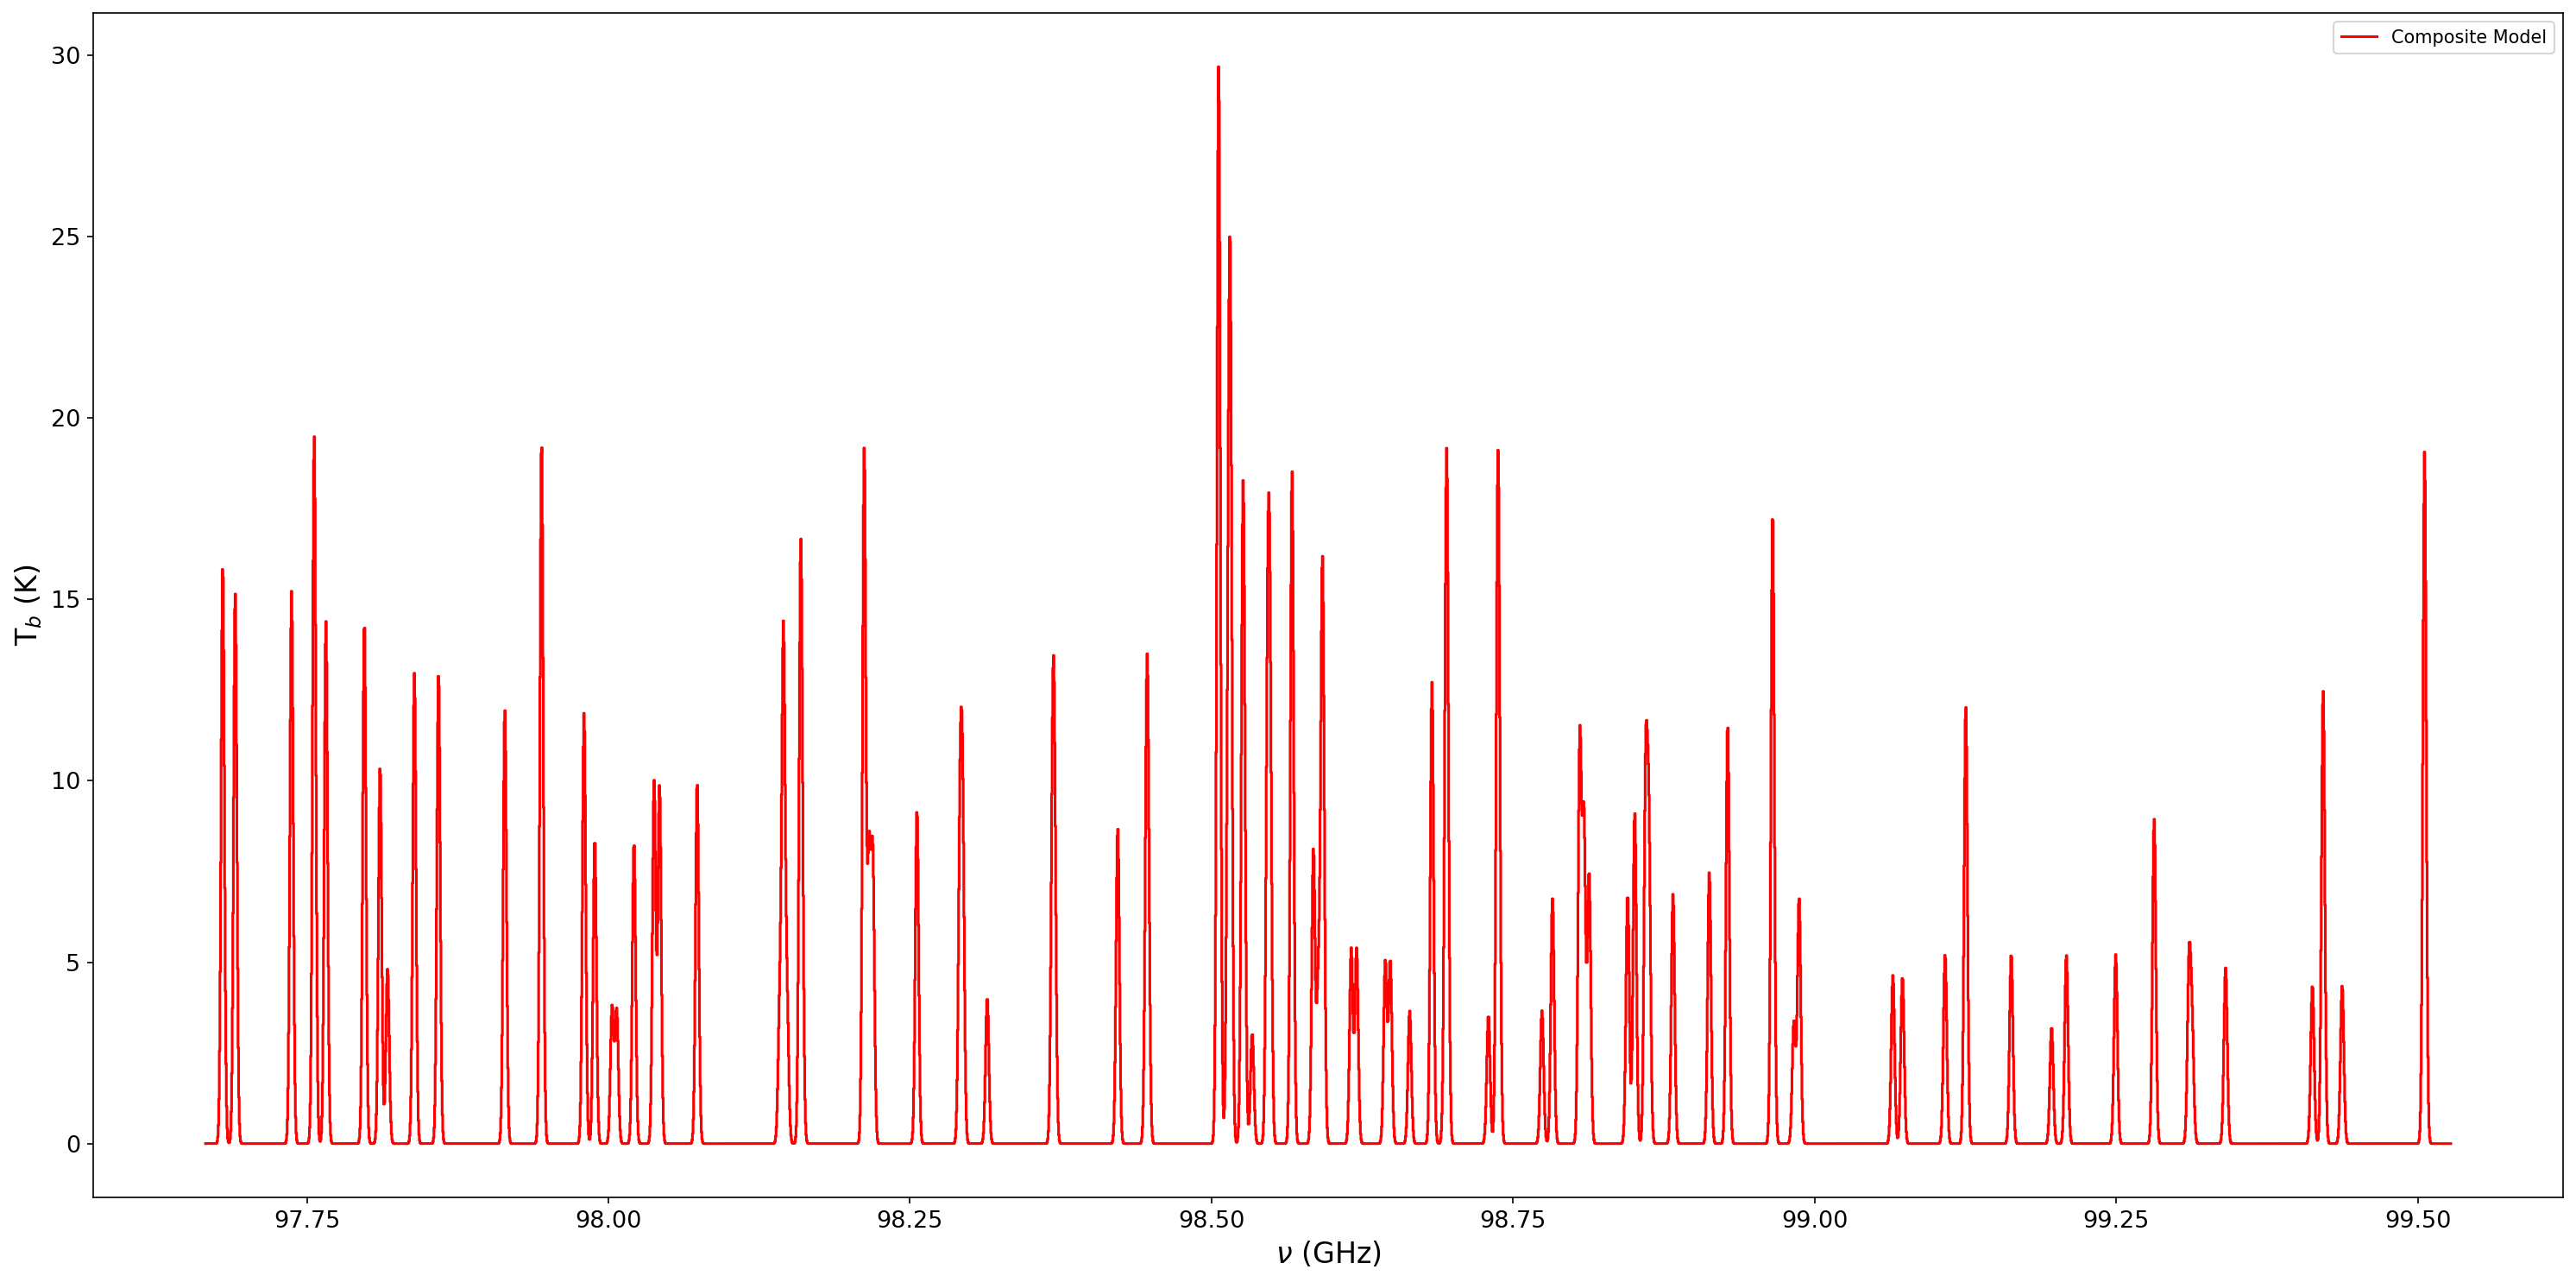

Getting ready - spw35
Extracted spectrum from 526, 1445 has peak 11.276950898168264 K
Extracted continuum from 644, 1535 has value 0.49287357015292577 K
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in spw35. Continue
No transitions for  OCS  in spw35. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
Begin model loops for  HC3N 
No transitions for  C(18)O  in spw35. Continue
No transitions for  13CS  in spw35. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in spw35. Continue
Begin model loops for  SO 
No transitions for  SiO  in spw35. Continue
No transitions for  H2S  in spw35. Continue
Begin model loops for  c-HCCCH 
Begin model loops for HC3N v7=1
No transitions 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Begin CH3OH modeling



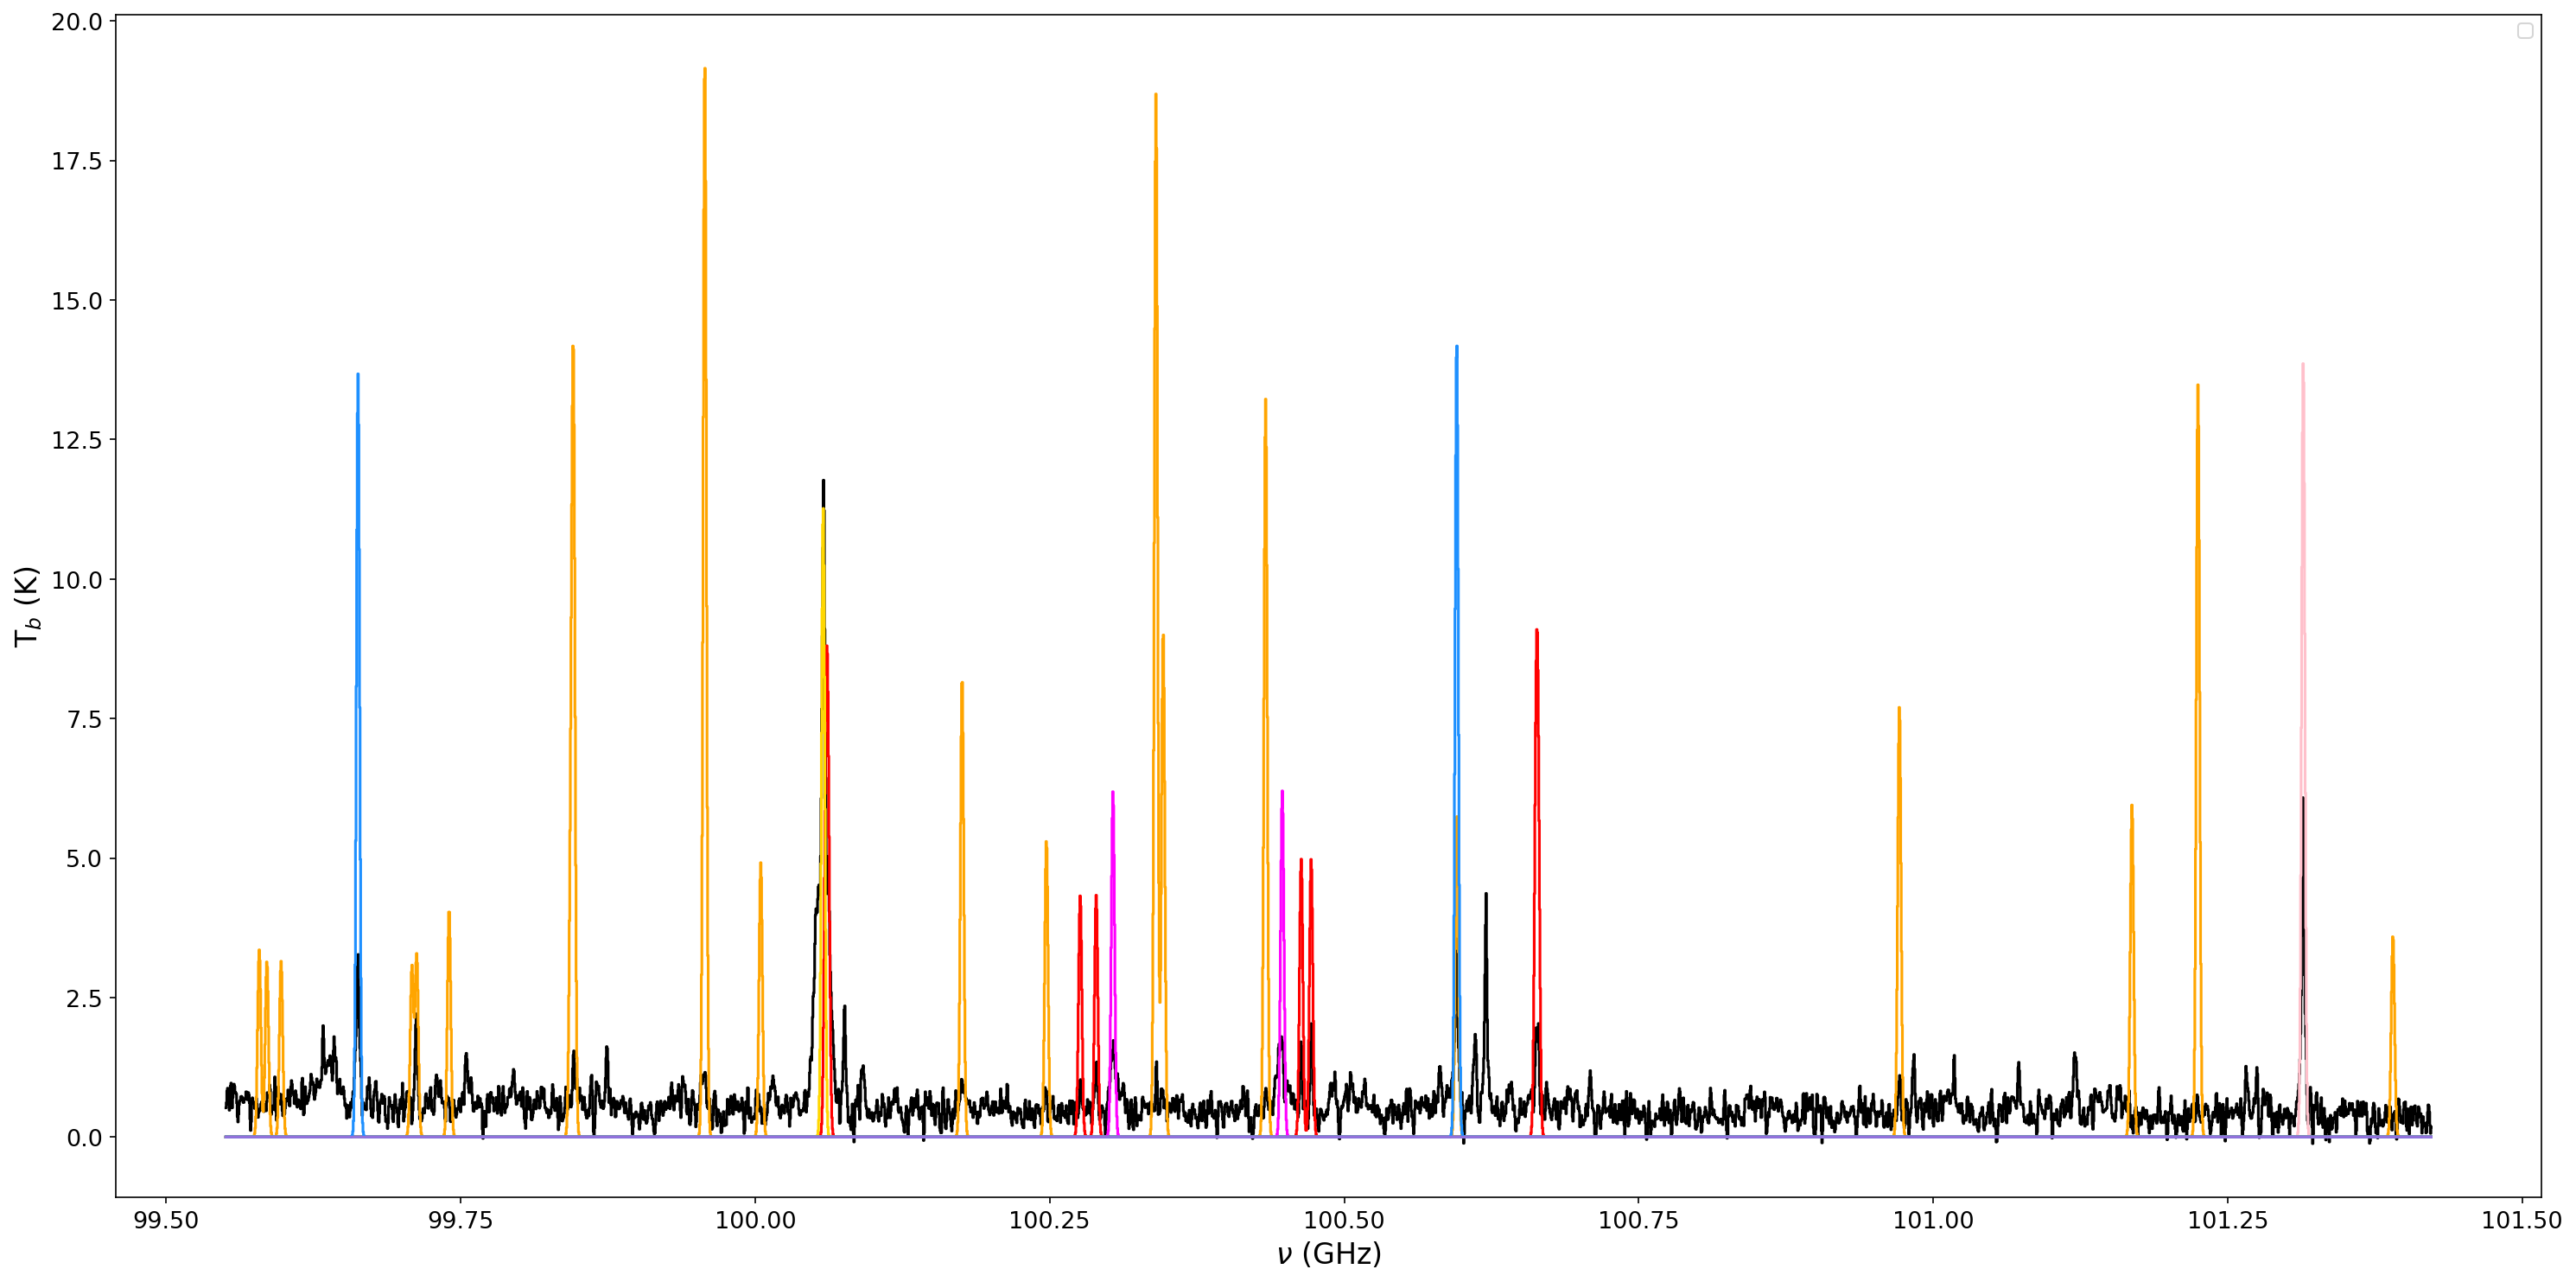

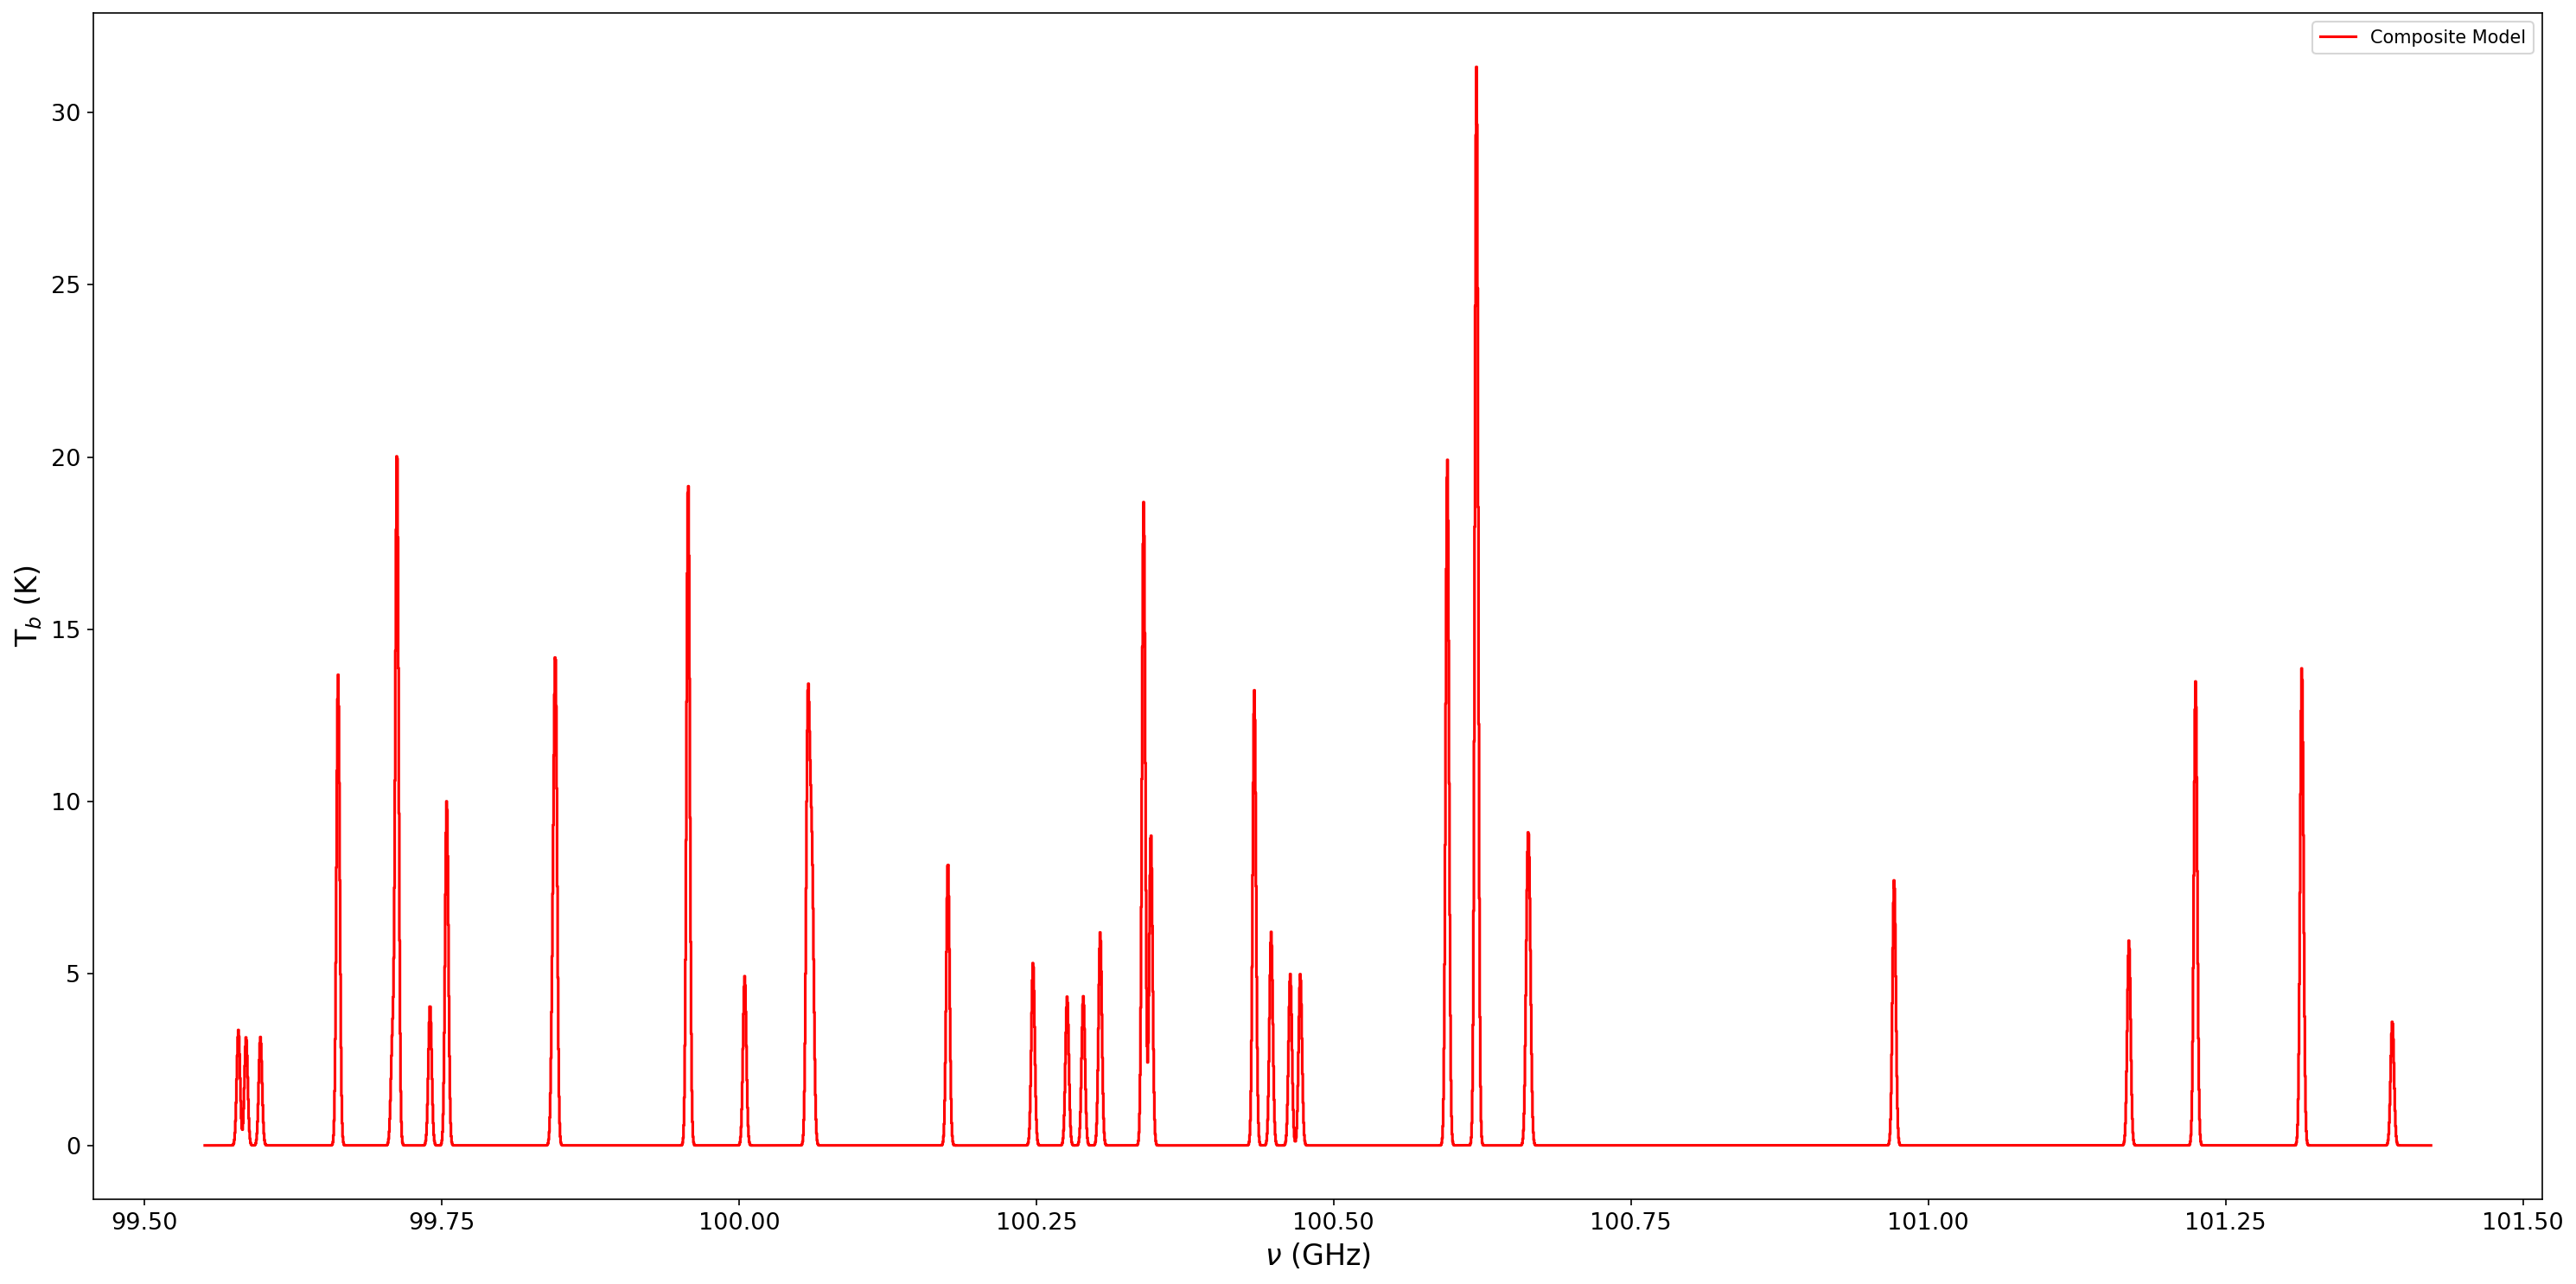

In [22]:
for spw, cubefn in aces_cubes.items():
    
    print(f'Getting ready - spw{spw}')
    plt.rcParams['figure.dpi'] = mode
    plt.figure(figsize=(20,10))
    n+=1
    if spw == 27:
        firstmolline=p2firstmolline
    if spw == 33:
        firstmolline=p3firstmolline
    if spw == 35:
        firstmolline=p4firstmolline
        
    cube = sc.read(cubefn)
    xx, yy = map(int, cube.wcs.celestial.world_to_pixel(coord))
    spectrum = cube[:, yy, xx].to(u.K)
    print(f"Extracted spectrum from {xx}, {yy} has peak {spectrum.max()}")

    xx, yy = map(int, continuum_cube.wcs.celestial.world_to_pixel(coord))
    continuum_level = continuum_cube[0][yy, xx]
    print(f"Extracted continuum from {xx}, {yy} has value {continuum_level}")
    
    #cube=sc.read(ace)
    freqs=cube.spectral_axis
    data=spectrum+continuum_level
    error=1*u.K#fits.getdata(stdimage)[targetpix[0],targetpix[1]]*u.K
    
    freqflip=False
    if freqs[0] > freqs[1]:
        freqs=freqs[::-1]
        data=data[::-1]
        freqflip=True
        print('Corrected decreasing frequency axis')
    else:
        pass
    
    freq_min=freqs.min().to('GHz')#*(1+z)#215*u.GHz
    freq_max=freqs.max().to('GHz')#*(1+z)#235*u.GHz
    
    assert freq_max > freq_min, 'Decreasing frequency axis'
    
    print('Plotting model spectra')
    #plt.plot(freqs.to('GHz').value,data.value,drawstyle='steps-mid',color='black')
    
    '''Generate methanol table for use during contaminant search'''
    #pdb.set_trace()
    Jfreqs, Jaij, Jdeg, JEU, qrot = get_molecular_parameters('CH3OH, vt=0-2', catalog='CDMS', fmin=freq_min, fmax=freq_max)
    
    qrot_partfunc=qrot(testT)
    print('Gathering CDMS table parameters')
    catdir_ch3oh=cdms_catdir[cdms_catdir['molecule'] == 'CH3OH, vt=0-2']
    mcatdir_qrot300=10**catdir_ch3oh['lg(Q(300))']
    methanol_table=CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule='032504 CH3OH, vt=0-2',get_query_payload=False)
    #Splatalogue.query_lines(freq_min, freq_max, chemical_name=' CH3OH ', energy_max=1840, energy_type='eu_k', line_lists=[linelistdict[' CH3OH ']], show_upper_degeneracy=True)
    mnus=methanol_table['FREQ']
    mlines=(mnus/(1+z)).to('GHz')#Redshifted to source
    
    melo_lambda=(1/methanol_table['ELO'].data)*u.cm
    melo_K=(((h*c)/melo_lambda)/k).to('K')
    melo_J=(melo_K*k).to('J')
    mdeltae=((h*methanol_table['FREQ'])/k).to('K')
    meuks=melo_K+mdeltae#maintable['EU_K']*u.K
    meujs=(meuks*k).to('J')
    mdegs=methanol_table['GUP']
    #Assembles the QNs for the molecule, not necessary in current implementation
    ju=methanol_table['Ju']
    jl=methanol_table['Jl']
    ku1=methanol_table['Ku']
    ku2=methanol_table['vu']
    kl1=methanol_table['Kl']
    kl2=methanol_table['vl']
    mqns=[]
    assert len(ju)==len(methanol_table) and len(jl)==len(methanol_table)
    for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
        tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
        mqns.append(tempqn)
    mlog10cdmsfluxes=methanol_table['LGINT']
    mcdmsfluxes=10**mlog10cdmsfluxes
    maijs=pickett_aul(mcdmsfluxes,mnus,mdegs,melo_J,meujs,mcatdir_qrot300,T=300*u.K)
    
    '''Create background model for the methanol lines and other species'''
    baseline=models.Linear1D(slope=(0*(u.K/u.Hz)),intercept=0*u.K)
    baseline.bounding_box=(freq_min.value,freq_max.value)
    methmodelspec=baseline
    compositebaseline=baseline
    plot=np.linspace(freq_min.value,freq_max.value,3840)*u.GHz
    modeldict={}
    plt.plot(freqs.to('GHz').value, data.value,
                 drawstyle='steps-mid', color='black')
    for molecule,hue,first in zip(list(columndict.keys())[1:], molcolors,list(firstmolline.keys())[1:]):
        '''Generate species table for contaminant search'''
        if molecule in jplnamelist.keys():
            molname=jplnamelist[molecule]
            cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='JPL', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
            species_catdir=jpl_catdir[jpl_catdir['NAME'] == jplnamelist[molecule]]
            species_catdirtag=str(species_catdir['TAG'][0])
            scatdir_qrot300=10**species_catdir['QLOG1']
            jplname=f'{species_catdirtag} {jplnamelist[molecule]}'
            species_table= JPLSpec.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=jplname,get_query_payload=False)
            if len(species_table) == 0 or type(species_table['FREQ'][0])==np.str_:
                print(f'No transitions for {molecule} in spw{spw}. Continue')
                continue
            else:
                modelspec=baseline
                cnus=species_table['FREQ']
                celo_lambda=(1/species_table['ELO'].data)*u.cm
                celo_K=(((h*c)/celo_lambda)/k).to('K')
                celo_J=(celo_K*k).to('J')
                cdeltae=((h*species_table['FREQ'])/k).to('K')
                ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
                ceujs=(ceuks*k).to('J')
                cdegs=species_table['GUP']
                clog10jplfluxes=species_table['LGINT']
                cjplfluxes=10**clog10jplfluxes
                caijs=pickett_aul(cjplfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
                cupqn=species_table['QN\'']
                clowqn=species_table['QN\"']
                cqns=[]
                for i, j in zip(cupqn,clowqn):
                    i=i.replace(i[(len(i)-2):],'')
                    i=i.replace(' ','.')
                    j=j.replace(j[(len(j)-2):],'')
                    j=j.replace(' ','.')
                    a=f'{i}-{j}'
                    cqns.append(a)
                #print(caijs)
                #sys.exit()
        elif molecule in cdmsnamelist.keys():
            molname=cdmsnamelist[molecule]
            cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='CDMS', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
            species_catdir=cdms_catdir[cdms_catdir['molecule'] == cdmsnamelist[molecule]]
            species_catdirtag=str(species_catdir['tag'][0])
            scatdir_qrot300=10**species_catdir['lg(Q(300))']
            cdmsname=f'0{species_catdirtag} {cdmsnamelist[molecule]}'
            species_table= CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=cdmsname,get_query_payload=False)
            if len(species_table) == 0 or type(species_table['FREQ'][0])==np.str_:
                print(f'No transitions for {molecule} in spw{spw}. Continue')
                continue
            else:
                modelspec=baseline
                cnus=species_table['FREQ']
                ju=species_table['Ju']
                jl=species_table['Jl']
                ku1=species_table['Ku']
                ku2=species_table['vu']
                kl1=species_table['Kl']
                kl2=species_table['vl']
                cqns=[]
                assert len(ju)==len(species_table) and len(jl)==len(species_table)
                for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
                    tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
                    cqns.append(tempqn)
                celo_lambda=(1/species_table['ELO'].data)*u.cm
                celo_K=(((h*c)/celo_lambda)/k).to('K')
                celo_J=(celo_K*k).to('J')
                cdeltae=((h*species_table['FREQ'])/k).to('K')
                ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
                ceujs=(ceuks*k).to('J')
                cdegs=species_table['GUP']
                clog10cdmsfluxes=species_table['LGINT']
                ccdmsfluxes=10**clog10cdmsfluxes
                caijs=pickett_aul(ccdmsfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
        
        #sys.exit()
        if molecule in incompleteqrot:
            print(f'{molecule} has an incomplete partition function')
            '''
            if molecule == ' CH3OCHO ':
                print('Using fiducial 300 K partition function as stopgap\n')
                c_qrot_partfunc=c_qrot(300*u.K)
            else:
            '''
            print('Estimating by linear fit to log-log Qrot/T relation')
            poly=Linear1D(slope=150, intercept=10)
            fitter=fitting.LinearLSQFitter()

            catdirkeys=list(species_catdir.keys())
            lgqrots_spec_catdir=np.array(list(species_catdir[catdirkeys[3:]].as_array()[0]))
            nonnanqrots=list(np.where(np.isnan(lgqrots_spec_catdir)==False)[0])
            temperatures_nonnanqrots=cdms_catdir_qrot_temps[nonnanqrots]

            fitinput_xvalues=temperatures_nonnanqrots#np.linspace(3,300,1000)*u.K
            power_law_fit=fitter(poly,np.log10(temperatures_nonnanqrots),np.log10(c_qrot(temperatures_nonnanqrots)))
            logintercept=10**power_law_fit.intercept
            logTs=logintercept*fitinput_xvalues**power_law_fit.slope
            c_qrot_partfunc=fit_qrot(logintercept,testT,power_law_fit)
        else:
            c_qrot_partfunc=c_qrot(testT)
            
        if molecule in othermol_dshift_v.keys():
            otherz=othermol_dshift_v[molecule]/c
            clines=cnus/(1+otherz)
        else:
            clines=cnus/(1+z)
    
        cntot=columndict[molecule]
        
        print(f'Begin model loops for {molecule}')
        firstmodelline=True 
        tempdetections=[]
        for line,deg,euj,aij,qn,euk in zip(clines,cdegs,ceujs,caijs,cqns,ceuks):
            if isinstance(line,float):
                line=line*u.MHz
            if molecule in othermol_dshift_v.keys():
                restline=line*(1+otherz)#*u.MHz
            else:
                restline=line*(1+z)#*u.MHz
            est_nupper=nupper_estimated(cntot,deg,c_qrot_partfunc,euj,testT).to('cm-2')
            modlinewidth=velocitytofreq(linewidth,line)#*u.MHz)
            lineprofilesigma=modlinewidth/2*np.sqrt(2*np.log(2))
            phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
            intertau=lte_molecule.line_tau(testT, cntot, c_qrot_partfunc, deg, restline, euj, aij) 
            est_tau=(intertau*phi_nu).to('')
            trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=testT).to('K')
            #print(f'{qn} - {trad} - {np.log10(est_nupper.value)} - {deg} - {aij} - {euj} - {line} - {modlinewidth}')
            if trad >= 3*error:
                modelline=models.Gaussian1D(mean=line, stddev=modlinewidth, amplitude=trad)
                modelspec+=modelline
                compositebaseline+=modelline
                if firstmodelline:# Updated to let us retrieve the parameters of the detected lines
                    tempdetections=QTable(rows=[[qn,restline.to('GHz'),line.to('GHz'),euk,deg,aij,trad,est_nupper]],names=['QNs','RestFrequency','ReferenceFrequency','Eupper','Degeneracy','Aij','ModelBrightness','ModelNupper'])
                    firstmodelline=False
                else:
                    tempdetections.add_row([qn,restline.to('GHz'),line.to('GHz'),euk,deg,aij,trad,est_nupper])
            else:
                continue       
        if molecule in linedetections.keys():
            linedetections[molecule]=vstack([linedetections[molecule], tempdetections])
        else:
            linedetections.update({molecule:tempdetections})
        if firstmolline[first]:
            plt.plot(plot.value,modelspec(plot),drawstyle='steps-mid',color=hue,label=molecule)
            firstmolline[first]=0
        else:
            plt.plot(plot.value,modelspec(plot),drawstyle='steps-mid',color=hue)
            
    if ' CH3OH ' in columndict:
        print('Begin CH3OH modeling\n')
        firstmodelline=True 
        tempch3ohdetections=[]
        for line,deg,euj,aij,qn,euk in zip(mlines,mdegs,meujs,maijs,mqns,meuks):
            #print(f'Transition: {qn} @ {line.to("GHz")}')
            restline=line*(1+z)
            modlinewidth=velocitytofreq(linewidth,line)
            lineprofilesigma=modlinewidth/2*np.sqrt(2*np.log(2))
            phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
            
            methntot=nch3oh_at_pix#columndict[' CH3OH ']
            est_nupper=nupper_estimated(methntot,deg,qrot_partfunc,euj,testT).to('cm-2')
            intertau=lte_molecule.line_tau(testT, methntot, qrot_partfunc, deg, restline, euj, aij)
            est_tau=(intertau*phi_nu).to('')
            #print(f'Estimated tau: {"{:.3f}".format(est_tau)}')
            trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=testT).to('K')
            if trad >= 3*error:
                #print(f'Estimated brightness: {"{:.3f}".format(trad)}')
                #print(f'Model linewidth (Hz): {modlinewidth}')
                modelline=models.Gaussian1D(mean=line, stddev=modlinewidth, amplitude=trad)
                #modelgaus+=modelline
                methmodelspec+=modelline
                compositebaseline+=modelline
                if firstmodelline:# and molecule not in linedetections.keys():
                    tempch3ohdetections=QTable(rows=[[qn,restline.to('GHz'),line.to('GHz'),euk,deg,aij,trad,est_nupper]],names=['QNs','RestFrequency','ReferenceFrequency','Eupper','Degeneracy','Aij','ModelBrightness','ModelNupper'])
                    firstmodelline=False
                else:
                    tempch3ohdetections.add_row([qn,restline.to('GHz'),line.to('GHz'),euk,deg,aij,trad,est_nupper])
            else:
                #print(f'{qn} line brightness ({"{:.3f}".format(trad)}) below 3sigma threshold ({3*error})')
                #tempmdetections.update({qn:False})
                continue
        if ' CH3OH ' in linedetections.keys():
            linedetections[' CH3OH ']=vstack([linedetections[' CH3OH '], tempch3ohdetections])
            #sys.exit()
        else:
            linedetections.update({' CH3OH ':tempch3ohdetections})
            
        if firstmolline[' CH3OH '] and len(linedetections[molecule]) > 0:
            plt.plot(freqs.to('GHz').value,methmodelspec(freqs.to('GHz')),drawstyle='steps-mid',linestyle='--',color='green',label=' CH3OH ')
            firstmolline[' CH3OH ']=0
            print('yay')
        elif len(linedetections[molecule]) > 0:
            plt.plot(freqs.to('GHz').value,methmodelspec(freqs.to('GHz')),drawstyle='steps-mid',linestyle='--',color='green')
            print('yayy')
    
    if spw == '':
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=95)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        #plt.savefig(fr'C:/Users/desmond/Desktop/submission_bootstrap_{source}_{img}_qrotfix_compositespectra.pdf')
        plt.show()
        
        plt.figure(figsize=(20,10))
        plt.plot(plot.value,compositebaseline(plot),drawstyle='steps-mid',color='red',label='Composite Model')
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=95)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.show()
    else:
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.xlim(xmin=(min(freqs.to('GHz'))-plotspecpad).value,xmax=(max(freqs.to('GHz'))+plotspecpad).value)
        #plt.ylim(ymax=35)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.savefig(fr'../plots/ACES/{source}_spw{spw}_individualizedspectra.pdf')
        plt.show()
        
        #plt.rcParams['figure.dpi'] = mode
        plt.figure(figsize=(20,10))
        #plt.plot(freqs.to('GHz').value,data.value,drawstyle='steps-mid',color='black',label='Data')
        plt.plot(plot.value,compositebaseline(plot),drawstyle='steps-mid',color='red',label='Composite Model')
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=35)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.savefig(fr'../plots/ACES/{source}_spw{spw}_compositespectra.pdf')
        plt.show()

In [21]:
linedetections[' C2H5OH ']['Eupper'].sort()
linedetections[' C2H5OH ']

QNs,RestFrequency,ReferenceFrequency,Eupper,Degeneracy,Aij,ModelBrightness,ModelNupper
,GHz,GHz,K,,Hz,K,1 / cm2
str17,float64,float64,float64,int64,float64,float64,float64
"18(4,14)-18(3,16)",86.13292570000002,86.11686490469528,35.173012276388874,37,1.5514276432066187e-06,3.3167356720925096,192940808835972.22
"5(2,4)-4(2,3)",86.3112818,86.29518774748507,74.19849254430288,11,4.47233435283023e-06,5.060902176719945,102920796630691.17
"5(2,4)-4(2,3)",86.3442025,86.32810230891938,74.25859573416433,11,4.2866678351943384e-06,4.758757333036818,100981238993034.2
"15(2,13)-15(1,14)",86.94727950000001,86.93106685603135,74.958725538772,31,5.749948899459296e-06,15.418217215411866,252975699733144.97
"5(2,3)-4(2,2)",87.02712410000001,87.0108965677901,78.91034023028973,11,4.375230959261648e-06,4.779986337107759,100957729555012.34
"5(2,3)-4(2,2)",87.0299985,87.01377043181445,78.96800613785506,11,4.576122666276311e-06,5.091797386777299,102895823042533.81
"27(1,27)-27(0,27)",97.6985211,97.68030372335558,79.63675691306213,55,1.1828869859707352e-05,15.979445618482867,161026373167805.72
"28(0,28)-28(1,28)",97.7088654,97.69064609450336,108.06890390107166,57,1.1863830330687914e-05,15.21946796800051,152697246579604.53


In [6]:
molecule

' CH3COCH3 '

In [49]:
mu=2*u.Dalton
ethanolmass=46.0684*u.Dalton
c2h5oh=4e17*u.cm**-2
r=3000*u.AU
n_c2h5oh=(c2h5oh*np.pi*r**2)/((4/3)*np.pi*r**3)
n_c2h5oh.to('cm-3')

<Quantity 6.68458712 1 / cm3>

In [47]:
(((c2h5oh*ethanolmass)*(np.pi*r**2)).to('kg'))/(0.35488235475*u.kg)

<Quantity 5.45595799e+26>

50.0